#EE769 Introduction to Machine Learning.
# ***Project Instructions***
# Assignment 2: Classifier Models and their performance.

**Name of Team Members**: Sayan Ray, Ashish Patel

**Roll No. of Members**: 213230011, 213350005

**We have been tasked to :**

1. Develop a Pre-processing pipeline and a Classifier.
2. Find out which subset of Proteins is important in predicting which class.

Specific Logistics:

1. Read the data directly from https://www.ee.iitb.ac.in/~asethi/Dump/MouseTrain.csv (do not upload)
2. (Done) Perform exploratory data analysis to find out:

a. Which variables are usable, and which are not?

b. Are there significant correlations among variables?

c. Are the classes balanced?

3. Develop a strategy to deal with missing variables. You can choose to impute the variable. The recommended way is to use multivariate feature imputation (https://scikit-learn.org/stable/modules/impute.html)
4. Select metrics that you will use, such as accuracy, F1 score, balanced accuracy, AUC etc. Remember, you have two separate classification tasks – one is binary, the other has four classes. You may have to do some reading about multi-class classification metrics.
5. Using five-fold cross-validation find the reasonable (I cannot say “best” because you have two separate classifications to perform) hyper-parameter settings for the following model types:

a. Elastic net logistic regression (L1 and L2 weight)

b. Neural network with single ReLU hidden layer and Softmax output (number of neurons, weight decay)

c. SVM (a few kernels, their hyper-parameters such as width, and slack penalty)

d. Random forest (number of trees, max tree depth, max number of variables per node)
6. Check feature importance for each model to see if the same proteins are important for each model. Read up on how to find feature importance.
7. See if removing some features systematically will improve your models (e.g. using recursive feature elimination https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html).
8. Finally, test a few promising models on the test data: https://www.ee.iitb.ac.in/~asethi/Dump/MouseTest.csv
9. Write your observations and thoughts
10. Write your references as well as other classmates outside of your team with whom you discussed


## Importing all the packages required.

In [108]:
#Importing the commonlu used function's libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math as mt
import seaborn as sns

# This is for the Imputaion of missing/nan data. 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

#import the module to perform standardization
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

#import the module to perform Principal Component Analysis
from sklearn.decomposition import PCA

# For selecting kBest features
from sklearn.feature_selection import SelectKBest

#import package to split the training data into the train and test dataset
from sklearn.model_selection import train_test_split 

# These packages are for the metrics of evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# These packages are for the grid search with kfold cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

#These are for the model implementation
from sklearn.linear_model import LogisticRegression #For Elastic Net Logistic Reggression
from sklearn.neural_network import MLPClassifier #For Neural Network with 1 ReLu Hidden + Softmax Output(Multi Class classifier)
from sklearn.svm import SVC #For SVM (All parameters to be tested)
from sklearn.ensemble import RandomForestClassifier #For Random Forest

# Lastly the package required for Recursive Feature Elimination with K fold Cross validation
from sklearn.feature_selection import RFECV

#This is specially for Neural Netorks
from sklearn.inspection import permutation_importance

# This extra pacakage is for presentation purpose
from IPython.display import clear_output

#In orer to display all the rows
pd.pandas.set_option('display.max_columns', None)

## Reading the training and testing data from the given urls.

In [109]:
#keeping the dataframes ready
train_url_path = "https://www.ee.iitb.ac.in/~asethi/Dump/MouseTrain.csv"
val_url_path = "https://www.ee.iitb.ac.in/~asethi/Dump/MouseTest.csv"
train_data_df = pd.read_csv( train_url_path )
val_data_df  = pd.read_csv( val_url_path )

print ("The Training Dataset Shape: "+str(train_data_df.shape))
print ("The Testing Dataset Shape: "+str(val_data_df.shape))

The Training Dataset Shape: (762, 79)
The Testing Dataset Shape: (225, 79)


## The Training Dataset

In [110]:
#Firstly we just view the data given, the proteins and the characteristics of the data.
display(train_data_df)

heading_list = train_data_df.columns.values.tolist()

#Extracting the data part only (since the last 2 coloumns are just the classifications)
train_df = train_data_df[heading_list[0:-2]]
print()
print ("The Training Dataset Shape (without classification coloumns): "+str(train_df.shape))
print()
display (train_df)

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
1    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
2    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
3    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.394169  0.623696  0.316564  2.104045  3.314706  0.234529  0.200657   
758  0.401739  0.659571  0.321841  2.183930  3.411782  0.236546  0.190826   
759  0.382182  0.586545  0.318545  2.072000  3.073636  0.259636  0.202727   
760  0.365622  0.572209  0.297992  2.004931  2.783551  0.245333  0.190384   
761  0.365605  0.599499  0.301539  2.062813  2.952577  0.248568  0.198819   

     pCAMKII_N   pCREB_N    pELK_N    pERK_N    pJNK_N    PKCA_N    pMEK_N  \
0     2.373744  0.232224  1.750936  0.687906  0.306382  0.402698  0.296927   
1     2.292150  0.226972  1.596377  0.695006  0.299051  0.385987  0.281319   
2     2.283337  0.230247  1.561316  0.677348  0.291276  0.381002  0.281710   
3     2.152301  0.207004  1.595086  0.583277  0.296729  0.377087  0.313832   
4     2.134014  0.192158  1.504230  0.550960  0.286961  0.363502  0.277964   
..         ...       ...       ...       ...       ...       ...       ...   
757   3.208804  0.221809  1.218951  0.467915  0.317851  0.306417  0.282836   
758   3.384350  0.231899  1.250487  0.476240  0.329786  0.323939  0.300555   
759   3.006364  0.223455  1.248727  0.442727  0.354545  0.324182  0.310364   
760   2.948221  0.217506  1.177527  0.432371  0.325819  0.310497  0.294646   
761   3.069435  0.226736  1.220472  0.436471  0.351288  0.310129  0.295991   

       pNR1_N   pNR2A_N   pNR2B_N  pPKCAB_N    pRSK_N     AKT_N    BRAF_N  \
0    1.022060  0.605673  1.877684  2.308745  0.441599  0.859366  0.416289   
1    0.956676  0.587559  1.725774  2.043037  0.445222  0.834659  0.400364   
2    1.003635  0.602449  1.731873  2.017984  0.467668  0.814329  0.399847   
3    0.875390  0.520293  1.566852  2.132754  0.477671  0.727705  0.385639   
4    0.864912  0.507990  1.480059  2.013697  0.483416  0.687794  0.367531   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.763756  0.666857  1.285980  1.449621  0.499929  0.642704  0.338002   
758  0.807525  0.709489  1.363664  1.489882  0.536801  0.678459  0.350772   
759  0.761818  0.657636  1.274000  1.499091  0.510545  0.635636  0.352364   
760  0.723846  0.649172  1.230187  1.384290  0.490490  0.607080  0.350123   
761  0.738726  0.660165  1.234789  1.414102  0.532749  0.630458  0.344667   

     CAMKII_N    CREB_N     ELK_N     ERK_N   GSK3B_N     JNK_N     MEK_N  \
0    0.369608  0.178944  1.866358  3.685247  1.537227  0.264526  0.319677   
1    0.356178  0.173680  1.761047  3.485287  1.509249  0.255727  0.304419   
2    0.368089  0.173905  1.765544  3.571456  1.501244  0.259614  0.311747   
3    0.362970  0.179449  1.286277  2.970137  1.419710  0.259536  0.279218   
4    0.355311  0.174836  1.324695  2.896334  1.359876  0.250705  0.273667   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.351722  0.192654  1.096470  2.320280  1.156496  0.234958  0.280549   
758  0.363664  0.207165  1.168490  2.508020  1.194124  0.252136  0.291710   
759  0.350727  0.210727  1.041636  2.137455  1.179818  0.254000  0.292909   
760  0.362452  0.207644  1.018669  2.070800  1.128566  0.237936  0.282494   
761  0.368468  0.206693  1.013422  2.131890  1.161238  0.275948  0.314424   

       TRKA_N     RSK_N     APP_N  Bcatenin_N    SOD1_N    MTOR_N     P38_N  \
0    0.813866  0.165846  0.453910    3.037621  0.369510  0.458539  0.335336   
1    0.780504  0.157194  0.430940    2.921882  0.342279  0.423560  0.324835   
2    0.785154  0.160895  0.423187    2.944136  0.343696 


The Training Dataset Shape (without classification coloumns): (762, 77)



DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
1    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
2    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
3    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.394169  0.623696  0.316564  2.104045  3.314706  0.234529  0.200657   
758  0.401739  0.659571  0.321841  2.183930  3.411782  0.236546  0.190826   
759  0.382182  0.586545  0.318545  2.072000  3.073636  0.259636  0.202727   
760  0.365622  0.572209  0.297992  2.004931  2.783551  0.245333  0.190384   
761  0.365605  0.599499  0.301539  2.062813  2.952577  0.248568  0.198819   

     pCAMKII_N   pCREB_N    pELK_N    pERK_N    pJNK_N    PKCA_N    pMEK_N  \
0     2.373744  0.232224  1.750936  0.687906  0.306382  0.402698  0.296927   
1     2.292150  0.226972  1.596377  0.695006  0.299051  0.385987  0.281319   
2     2.283337  0.230247  1.561316  0.677348  0.291276  0.381002  0.281710   
3     2.152301  0.207004  1.595086  0.583277  0.296729  0.377087  0.313832   
4     2.134014  0.192158  1.504230  0.550960  0.286961  0.363502  0.277964   
..         ...       ...       ...       ...       ...       ...       ...   
757   3.208804  0.221809  1.218951  0.467915  0.317851  0.306417  0.282836   
758   3.384350  0.231899  1.250487  0.476240  0.329786  0.323939  0.300555   
759   3.006364  0.223455  1.248727  0.442727  0.354545  0.324182  0.310364   
760   2.948221  0.217506  1.177527  0.432371  0.325819  0.310497  0.294646   
761   3.069435  0.226736  1.220472  0.436471  0.351288  0.310129  0.295991   

       pNR1_N   pNR2A_N   pNR2B_N  pPKCAB_N    pRSK_N     AKT_N    BRAF_N  \
0    1.022060  0.605673  1.877684  2.308745  0.441599  0.859366  0.416289   
1    0.956676  0.587559  1.725774  2.043037  0.445222  0.834659  0.400364   
2    1.003635  0.602449  1.731873  2.017984  0.467668  0.814329  0.399847   
3    0.875390  0.520293  1.566852  2.132754  0.477671  0.727705  0.385639   
4    0.864912  0.507990  1.480059  2.013697  0.483416  0.687794  0.367531   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.763756  0.666857  1.285980  1.449621  0.499929  0.642704  0.338002   
758  0.807525  0.709489  1.363664  1.489882  0.536801  0.678459  0.350772   
759  0.761818  0.657636  1.274000  1.499091  0.510545  0.635636  0.352364   
760  0.723846  0.649172  1.230187  1.384290  0.490490  0.607080  0.350123   
761  0.738726  0.660165  1.234789  1.414102  0.532749  0.630458  0.344667   

     CAMKII_N    CREB_N     ELK_N     ERK_N   GSK3B_N     JNK_N     MEK_N  \
0    0.369608  0.178944  1.866358  3.685247  1.537227  0.264526  0.319677   
1    0.356178  0.173680  1.761047  3.485287  1.509249  0.255727  0.304419   
2    0.368089  0.173905  1.765544  3.571456  1.501244  0.259614  0.311747   
3    0.362970  0.179449  1.286277  2.970137  1.419710  0.259536  0.279218   
4    0.355311  0.174836  1.324695  2.896334  1.359876  0.250705  0.273667   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.351722  0.192654  1.096470  2.320280  1.156496  0.234958  0.280549   
758  0.363664  0.207165  1.168490  2.508020  1.194124  0.252136  0.291710   
759  0.350727  0.210727  1.041636  2.137455  1.179818  0.254000  0.292909   
760  0.362452  0.207644  1.018669  2.070800  1.128566  0.237936  0.282494   
761  0.368468  0.206693  1.013422  2.131890  1.161238  0.275948  0.314424   

       TRKA_N     RSK_N     APP_N  Bcatenin_N    SOD1_N    MTOR_N     P38_N  \
0    0.813866  0.165846  0.453910    3.037621  0.369510  0.458539  0.335336   
1    0.780504  0.157194  0.430940    2.921882  0.342279  0.423560  0.324835   
2    0.785154  0.160895  0.423187    2.944136  0.343696 

# ***Exploratory  Data  Analysis, cleaning and feature elimination section.***

---



## Numerical Aspects~

---



## Checking for the number of unique values in each column and number of features along with null entries in the dataset.





In [111]:
# This part is inspired from Amit Sir's Lecuture on ML for Smart Monkeys

#checking the unique values and features with missing entities
# c is just the counter of the proteins, used for labelling.
c = 1

for col in train_df.columns.values:
  list_vals = pd.unique(train_df[col])
  # So isnull() scans the missing values and then we sum it up.
  print(str(c) +". "+col + " is of type " + str(train_df[col].dtypes) + " has " + str(len(list_vals)) + " unique values, and " + str(train_df[col].isnull().sum(axis=0)) + " null entries")
  c = c + 1
  if len(list_vals) < 10:
    list_str=""
    for n_value in range (0,len(list_vals)):
      list_str = list_str + str(list_vals[n_value]) + ','
    print("These are: " + list_str[0:-1])

1. DYRK1A_N is of type float64 has 762 unique values, and 0 null entries
2. ITSN1_N is of type float64 has 761 unique values, and 0 null entries
3. BDNF_N is of type float64 has 762 unique values, and 0 null entries
4. NR1_N is of type float64 has 762 unique values, and 0 null entries
5. NR2A_N is of type float64 has 762 unique values, and 0 null entries
6. pAKT_N is of type float64 has 762 unique values, and 0 null entries
7. pBRAF_N is of type float64 has 760 unique values, and 0 null entries
8. pCAMKII_N is of type float64 has 762 unique values, and 0 null entries
9. pCREB_N is of type float64 has 762 unique values, and 0 null entries
10. pELK_N is of type float64 has 762 unique values, and 0 null entries
11. pERK_N is of type float64 has 762 unique values, and 0 null entries
12. pJNK_N is of type float64 has 761 unique values, and 0 null entries
13. PKCA_N is of type float64 has 762 unique values, and 0 null entries
14. pMEK_N is of type float64 has 762 unique values, and 0 null en

**Conclusion**

In effect all the variables are continous type, no discrete type of data as evident from the data above.


In [112]:
# Now we check the percentage of missing values for the feature actually missing it.

# Its just a summarization from the list above

# We list out the features which has missing values (atleast one)
feat_with_missVal = [features for features in train_df.columns if train_df[features].isnull().sum()>1]

for feature in feat_with_missVal:
    print(feature,' has :', np.round(100 * train_df[feature].isnull().mean(), 4),  ' % missing values')


ELK_N  has : 1.9685  % missing values
MEK_N  has : 0.5249  % missing values
Bcatenin_N  has : 1.9685  % missing values
BAD_N  has : 23.622  % missing values
BCL2_N  has : 25.5906  % missing values
pCFOS_N  has : 7.874  % missing values
H3AcK18_N  has : 19.685  % missing values
EGR1_N  has : 23.622  % missing values
H3MeK4_N  has : 23.622  % missing values


Variables with null entries are as listed:

1. ELK_N with 748 unique values, and 15 null entries
2. MEK_N with 759 unique values, and 4 null entries
3. Bcatenin_N with 748 unique values, and 15 null entries
4. BAD_N with 582 unique values, and 180 null entries
5. BCL2_N with 568 unique values, and 195 null entries
6. pCFOS_N with 703 unique values, and 60 null entries
7. H3AcK18_N with 613 unique values, and 150 null entries
8. EGR1_N with 583 unique values, and 180 null entries
9. H3MeK4_N with 583 unique values, and 180 null entries

# We have chose to impute the features with missing data because its they are important for predictions for the given dataset, barely 25% missing so a simple imputation will suffice. I have decided to impute them.

## Now We'll Impute the missing values.

In [113]:
# This has been inspired from the link that sir had provided us with.
display(train_df)
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(train_df)
imputed_dataset = imp.transform(train_df)
#now the retun is an numpy 2D array

# while in section - The dataset we had defined heading_list taking the entire but last two coloumn names we reform the dataframe train_df
train_df = pd.DataFrame(imputed_dataset, columns = heading_list[0:-2])
display(train_df)

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
1    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
2    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
3    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.394169  0.623696  0.316564  2.104045  3.314706  0.234529  0.200657   
758  0.401739  0.659571  0.321841  2.183930  3.411782  0.236546  0.190826   
759  0.382182  0.586545  0.318545  2.072000  3.073636  0.259636  0.202727   
760  0.365622  0.572209  0.297992  2.004931  2.783551  0.245333  0.190384   
761  0.365605  0.599499  0.301539  2.062813  2.952577  0.248568  0.198819   

     pCAMKII_N   pCREB_N    pELK_N    pERK_N    pJNK_N    PKCA_N    pMEK_N  \
0     2.373744  0.232224  1.750936  0.687906  0.306382  0.402698  0.296927   
1     2.292150  0.226972  1.596377  0.695006  0.299051  0.385987  0.281319   
2     2.283337  0.230247  1.561316  0.677348  0.291276  0.381002  0.281710   
3     2.152301  0.207004  1.595086  0.583277  0.296729  0.377087  0.313832   
4     2.134014  0.192158  1.504230  0.550960  0.286961  0.363502  0.277964   
..         ...       ...       ...       ...       ...       ...       ...   
757   3.208804  0.221809  1.218951  0.467915  0.317851  0.306417  0.282836   
758   3.384350  0.231899  1.250487  0.476240  0.329786  0.323939  0.300555   
759   3.006364  0.223455  1.248727  0.442727  0.354545  0.324182  0.310364   
760   2.948221  0.217506  1.177527  0.432371  0.325819  0.310497  0.294646   
761   3.069435  0.226736  1.220472  0.436471  0.351288  0.310129  0.295991   

       pNR1_N   pNR2A_N   pNR2B_N  pPKCAB_N    pRSK_N     AKT_N    BRAF_N  \
0    1.022060  0.605673  1.877684  2.308745  0.441599  0.859366  0.416289   
1    0.956676  0.587559  1.725774  2.043037  0.445222  0.834659  0.400364   
2    1.003635  0.602449  1.731873  2.017984  0.467668  0.814329  0.399847   
3    0.875390  0.520293  1.566852  2.132754  0.477671  0.727705  0.385639   
4    0.864912  0.507990  1.480059  2.013697  0.483416  0.687794  0.367531   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.763756  0.666857  1.285980  1.449621  0.499929  0.642704  0.338002   
758  0.807525  0.709489  1.363664  1.489882  0.536801  0.678459  0.350772   
759  0.761818  0.657636  1.274000  1.499091  0.510545  0.635636  0.352364   
760  0.723846  0.649172  1.230187  1.384290  0.490490  0.607080  0.350123   
761  0.738726  0.660165  1.234789  1.414102  0.532749  0.630458  0.344667   

     CAMKII_N    CREB_N     ELK_N     ERK_N   GSK3B_N     JNK_N     MEK_N  \
0    0.369608  0.178944  1.866358  3.685247  1.537227  0.264526  0.319677   
1    0.356178  0.173680  1.761047  3.485287  1.509249  0.255727  0.304419   
2    0.368089  0.173905  1.765544  3.571456  1.501244  0.259614  0.311747   
3    0.362970  0.179449  1.286277  2.970137  1.419710  0.259536  0.279218   
4    0.355311  0.174836  1.324695  2.896334  1.359876  0.250705  0.273667   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.351722  0.192654  1.096470  2.320280  1.156496  0.234958  0.280549   
758  0.363664  0.207165  1.168490  2.508020  1.194124  0.252136  0.291710   
759  0.350727  0.210727  1.041636  2.137455  1.179818  0.254000  0.292909   
760  0.362452  0.207644  1.018669  2.070800  1.128566  0.237936  0.282494   
761  0.368468  0.206693  1.013422  2.131890  1.161238  0.275948  0.314424   

       TRKA_N     RSK_N     APP_N  Bcatenin_N    SOD1_N    MTOR_N     P38_N  \
0    0.813866  0.165846  0.453910    3.037621  0.369510  0.458539  0.335336   
1    0.780504  0.157194  0.430940    2.921882  0.342279  0.423560  0.324835   
2    0.785154  0.160895  0.423187    2.944136  0.343696 

DYRK1A_N   ITSN1_N    BDNF_N     NR1_N    NR2A_N    pAKT_N   pBRAF_N  \
0    0.503644  0.747193  0.430175  2.816329  5.990152  0.218830  0.177565   
1    0.514617  0.689064  0.411770  2.789514  5.685038  0.211636  0.172817   
2    0.509183  0.730247  0.418309  2.687201  5.622059  0.209011  0.175722   
3    0.442107  0.617076  0.358626  2.466947  4.979503  0.222886  0.176463   
4    0.434940  0.617430  0.358802  2.365785  4.718679  0.213106  0.173627   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.394169  0.623696  0.316564  2.104045  3.314706  0.234529  0.200657   
758  0.401739  0.659571  0.321841  2.183930  3.411782  0.236546  0.190826   
759  0.382182  0.586545  0.318545  2.072000  3.073636  0.259636  0.202727   
760  0.365622  0.572209  0.297992  2.004931  2.783551  0.245333  0.190384   
761  0.365605  0.599499  0.301539  2.062813  2.952577  0.248568  0.198819   

     pCAMKII_N   pCREB_N    pELK_N    pERK_N    pJNK_N    PKCA_N    pMEK_N  \
0     2.373744  0.232224  1.750936  0.687906  0.306382  0.402698  0.296927   
1     2.292150  0.226972  1.596377  0.695006  0.299051  0.385987  0.281319   
2     2.283337  0.230247  1.561316  0.677348  0.291276  0.381002  0.281710   
3     2.152301  0.207004  1.595086  0.583277  0.296729  0.377087  0.313832   
4     2.134014  0.192158  1.504230  0.550960  0.286961  0.363502  0.277964   
..         ...       ...       ...       ...       ...       ...       ...   
757   3.208804  0.221809  1.218951  0.467915  0.317851  0.306417  0.282836   
758   3.384350  0.231899  1.250487  0.476240  0.329786  0.323939  0.300555   
759   3.006364  0.223455  1.248727  0.442727  0.354545  0.324182  0.310364   
760   2.948221  0.217506  1.177527  0.432371  0.325819  0.310497  0.294646   
761   3.069435  0.226736  1.220472  0.436471  0.351288  0.310129  0.295991   

       pNR1_N   pNR2A_N   pNR2B_N  pPKCAB_N    pRSK_N     AKT_N    BRAF_N  \
0    1.022060  0.605673  1.877684  2.308745  0.441599  0.859366  0.416289   
1    0.956676  0.587559  1.725774  2.043037  0.445222  0.834659  0.400364   
2    1.003635  0.602449  1.731873  2.017984  0.467668  0.814329  0.399847   
3    0.875390  0.520293  1.566852  2.132754  0.477671  0.727705  0.385639   
4    0.864912  0.507990  1.480059  2.013697  0.483416  0.687794  0.367531   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.763756  0.666857  1.285980  1.449621  0.499929  0.642704  0.338002   
758  0.807525  0.709489  1.363664  1.489882  0.536801  0.678459  0.350772   
759  0.761818  0.657636  1.274000  1.499091  0.510545  0.635636  0.352364   
760  0.723846  0.649172  1.230187  1.384290  0.490490  0.607080  0.350123   
761  0.738726  0.660165  1.234789  1.414102  0.532749  0.630458  0.344667   

     CAMKII_N    CREB_N     ELK_N     ERK_N   GSK3B_N     JNK_N     MEK_N  \
0    0.369608  0.178944  1.866358  3.685247  1.537227  0.264526  0.319677   
1    0.356178  0.173680  1.761047  3.485287  1.509249  0.255727  0.304419   
2    0.368089  0.173905  1.765544  3.571456  1.501244  0.259614  0.311747   
3    0.362970  0.179449  1.286277  2.970137  1.419710  0.259536  0.279218   
4    0.355311  0.174836  1.324695  2.896334  1.359876  0.250705  0.273667   
..        ...       ...       ...       ...       ...       ...       ...   
757  0.351722  0.192654  1.096470  2.320280  1.156496  0.234958  0.280549   
758  0.363664  0.207165  1.168490  2.508020  1.194124  0.252136  0.291710   
759  0.350727  0.210727  1.041636  2.137455  1.179818  0.254000  0.292909   
760  0.362452  0.207644  1.018669  2.070800  1.128566  0.237936  0.282494   
761  0.368468  0.206693  1.013422  2.131890  1.161238  0.275948  0.314424   

       TRKA_N     RSK_N     APP_N  Bcatenin_N    SOD1_N    MTOR_N     P38_N  \
0    0.813866  0.165846  0.453910    3.037621  0.369510  0.458539  0.335336   
1    0.780504  0.157194  0.430940    2.921882  0.342279  0.423560  0.324835   
2    0.785154  0.160895  0.423187    2.944136  0.343696 

## Class Balance

## Binary Class

It has 435 - 'Control' and 327 - 'Ts65Dn'

Percentages are is 57.08 % to 42.92 %

SO, WE CAN SAY THAT THEY ARE ALMOST BALANCED.

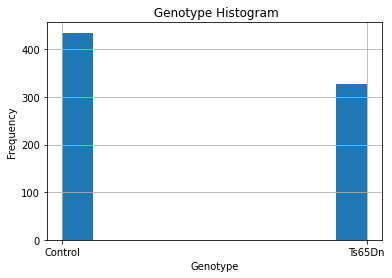

In [114]:
train_data_df['Genotype'].hist()
plt.xlabel('Genotype')
plt.ylabel("Frequency")
plt.title(" Genotype Histogram")
plt.show()

## Multi Class

It has 

225 - 'Memantin_C/S'  -  29.52%

225 - 'Memantin_S/C'  -  29.52%

180 - 'Saline_C/S'    -  23.62%

132 - 'Saline_S/C'    -  17.34%

SO, WELL ALTHOUGH THE LAST CLASS IS LESS IN TERMS OF QUANTITY, IT FALLS TO ABOUT 70% OF THE DESIRED BALANCE 25% AMONG ALL THE OTHER CLASSES CAN CONSIDER THIS DATASET. SINCE WE ONLY HAVE A FEW SAMPLES REDUCTION WILL COST US A LOT SINCE IT WILL BE REDUCtion ACROSS ALL THE OTHER 3 CLASSES. WITH LESS THAN 1000 SAMPLES IN HAND WE DECIDED TO RETAIN THIS CONFIGURATION FOR THE MILTO CLASS CLASSIFICATION (later we found that it had costed us as well).

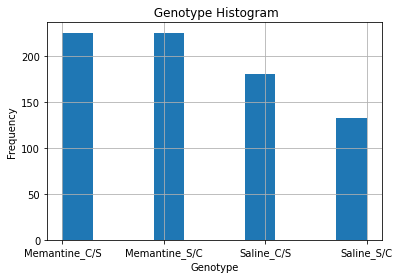

In [115]:
train_data_df['Treatment_Behavior'].hist()
plt.xlabel('Genotype')
plt.ylabel("Frequency")
plt.title(" Genotype Histogram")
plt.show()

## Visual data representation~

---



## Checking the Box plot of each feature.

This is just to get a feel of the range and variations and outliers of the data.

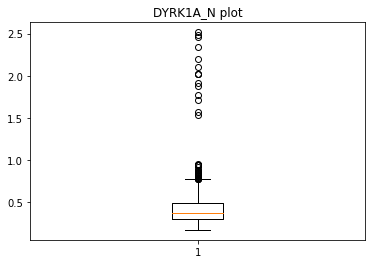


Mean :0.4377153476968504,  Max :0.170634038,  Min :0.170634038



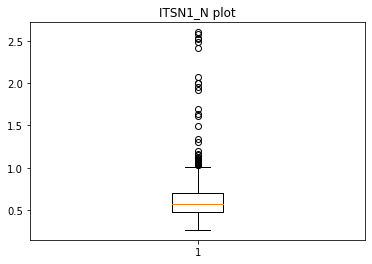


Mean :0.6294556964422572,  Max :0.264085228,  Min :0.264085228



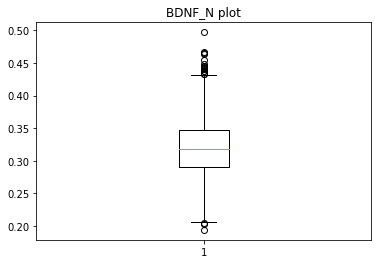


Mean :0.3198441010446194,  Max :0.194159569,  Min :0.194159569



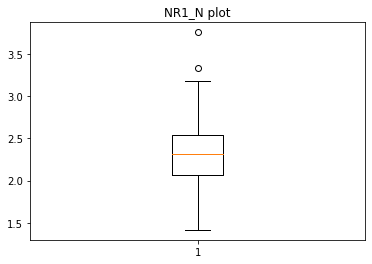


Mean :2.311904633813648,  Max :1.414913958,  Min :1.414913958



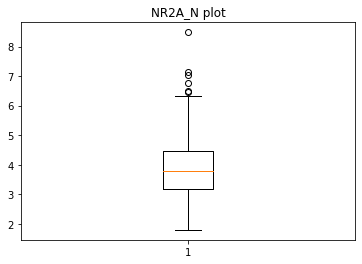


Mean :3.882664695779528,  Max :1.7947158,  Min :1.7947158



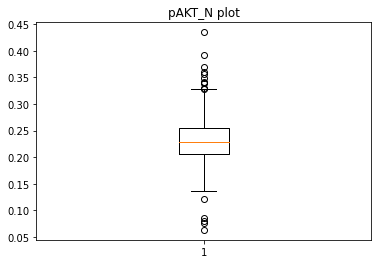


Mean :0.2327219455774278,  Max :0.063236006,  Min :0.063236006



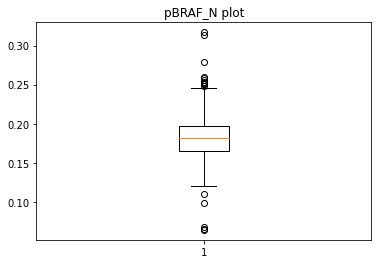


Mean :0.18251416383595798,  Max :0.064042588,  Min :0.064042588



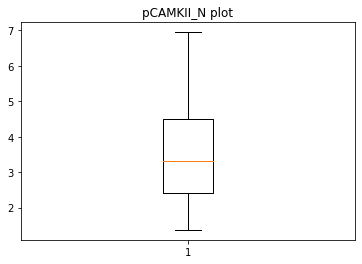


Mean :3.5130545965301834,  Max :1.369897959,  Min :1.369897959



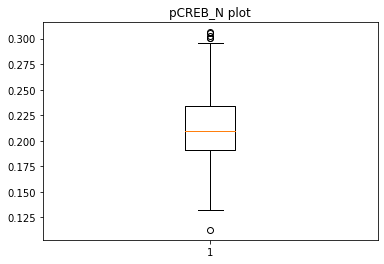


Mean :0.21208291293963252,  Max :0.112811791,  Min :0.112811791



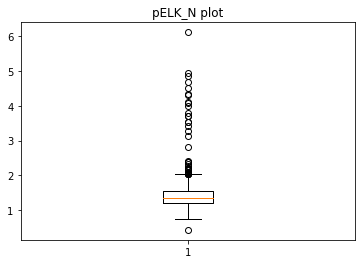


Mean :1.447200722276903,  Max :0.429032258,  Min :0.429032258



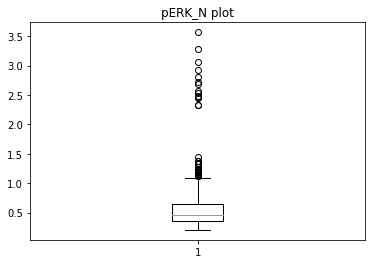


Mean :0.5634080290065617,  Max :0.205695554,  Min :0.205695554



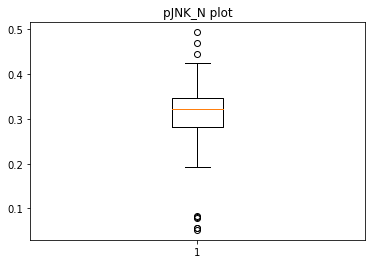


Mean :0.31398434539895015,  Max :0.05211039,  Min :0.05211039



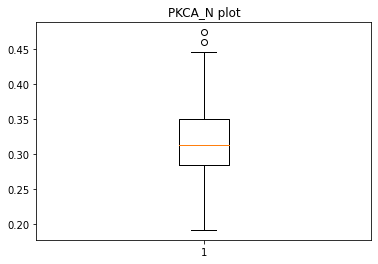


Mean :0.31791137204593173,  Max :0.191430693,  Min :0.191430693



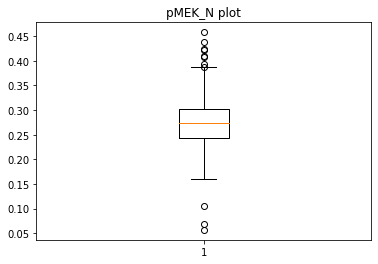


Mean :0.2750155939698163,  Max :0.056818182,  Min :0.056818182



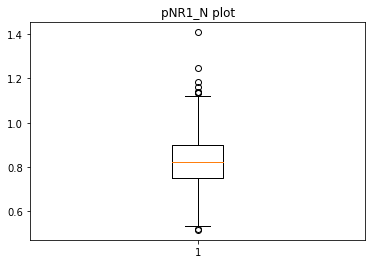


Mean :0.8301626865144357,  Max :0.516773857,  Min :0.516773857



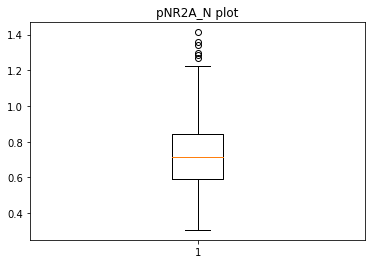


Mean :0.7241541655170605,  Max :0.30583393,  Min :0.30583393



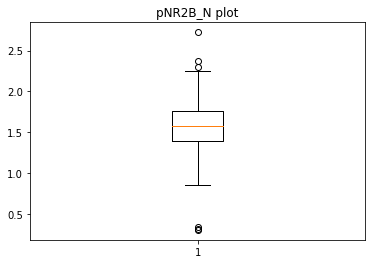


Mean :1.5763952641929135,  Max :0.301608579,  Min :0.301608579



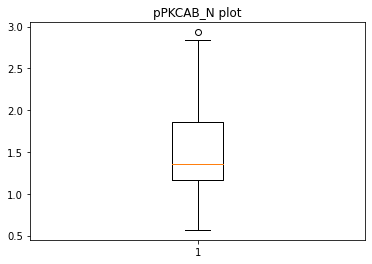


Mean :1.517021968351706,  Max :0.567840497,  Min :0.567840497



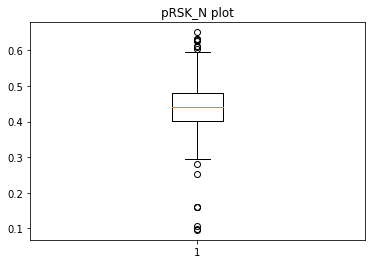


Mean :0.44224705400524933,  Max :0.095941558,  Min :0.095941558



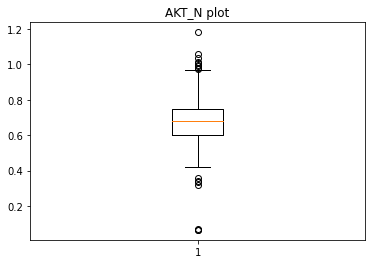


Mean :0.6819855086850395,  Max :0.06442119,  Min :0.06442119



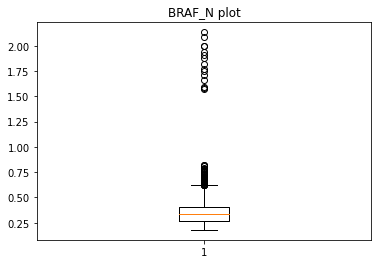


Mean :0.3906116177099737,  Max :0.17947142,  Min :0.17947142



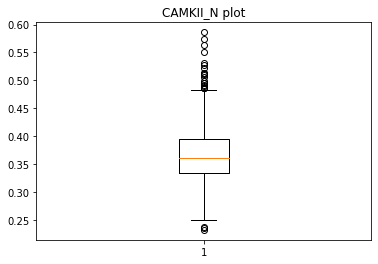


Mean :0.3666758751837271,  Max :0.232400487,  Min :0.232400487



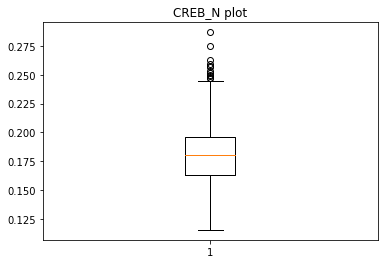


Mean :0.18141264093307086,  Max :0.115504535,  Min :0.115504535



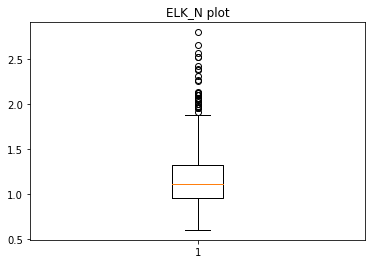


Mean :1.185750583300153,  Max :0.604554146,  Min :0.604554146



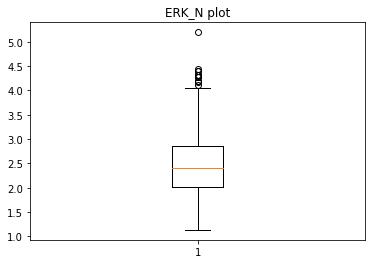


Mean :2.4843940500879262,  Max :1.131795717,  Min :1.131795717



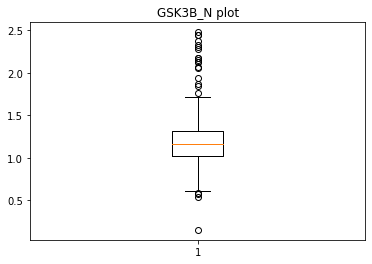


Mean :1.1797026225958005,  Max :0.151124339,  Min :0.151124339



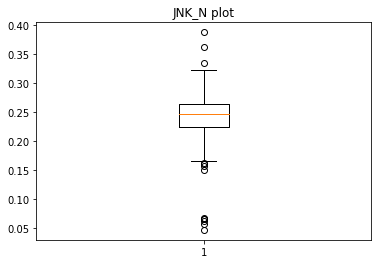


Mean :0.24306379711548556,  Max :0.04629779,  Min :0.04629779



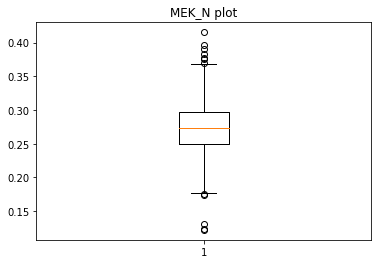


Mean :0.27290563451384175,  Max :0.12196300496073983,  Min :0.12196300496073983



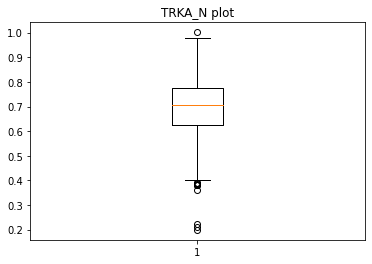


Mean :0.6971105996246718,  Max :0.198743386,  Min :0.198743386



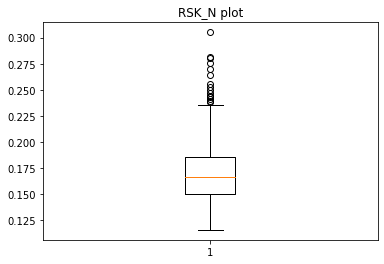


Mean :0.16974716217585303,  Max :0.115706862,  Min :0.115706862



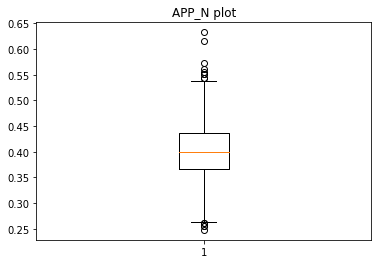


Mean :0.40203619391207346,  Max :0.24785237,  Min :0.24785237



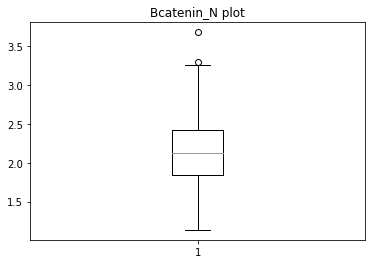


Mean :2.1509870921503347,  Max :1.134886146,  Min :1.134886146



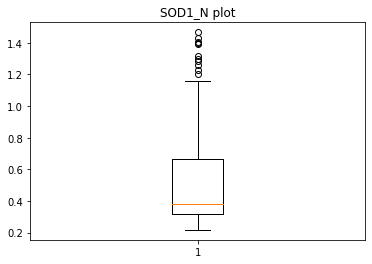


Mean :0.5116936231141732,  Max :0.217120181,  Min :0.217120181



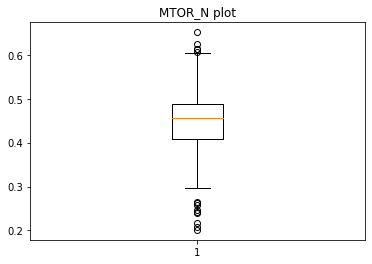


Mean :0.44982212718897635,  Max :0.20114336,  Min :0.20114336



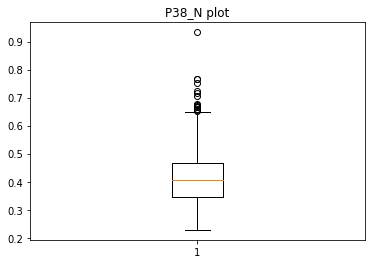


Mean :0.41400293050131237,  Max :0.227880387,  Min :0.227880387



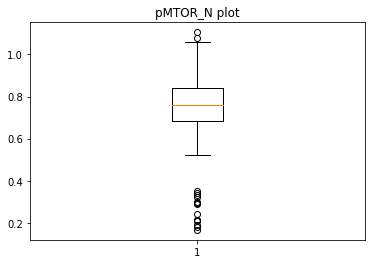


Mean :0.7581430413556431,  Max :0.166578716,  Min :0.166578716



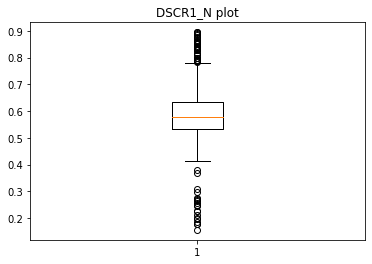


Mean :0.5826312804566929,  Max :0.15532102,  Min :0.15532102



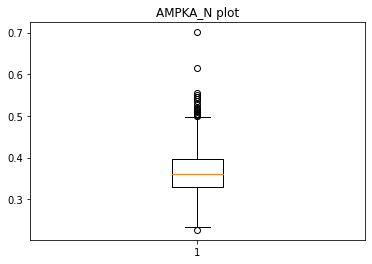


Mean :0.3686951726338582,  Max :0.22640869,  Min :0.22640869



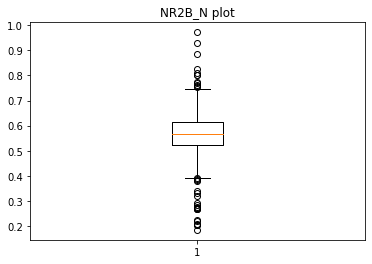


Mean :0.5654925237808398,  Max :0.184784521,  Min :0.184784521



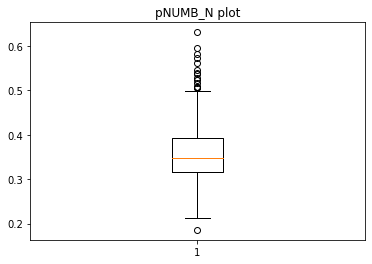


Mean :0.3580454025787402,  Max :0.185597624,  Min :0.185597624



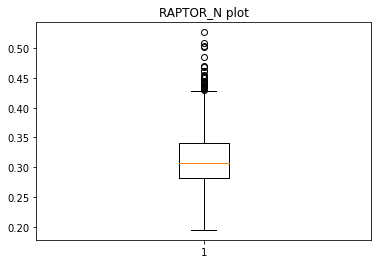


Mean :0.31472316737401573,  Max :0.194824478,  Min :0.194824478



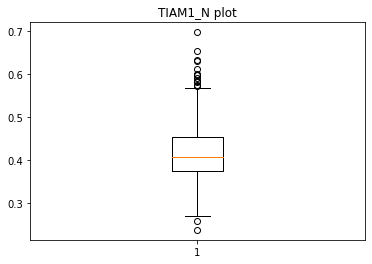


Mean :0.41657944293307086,  Max :0.237777071,  Min :0.237777071



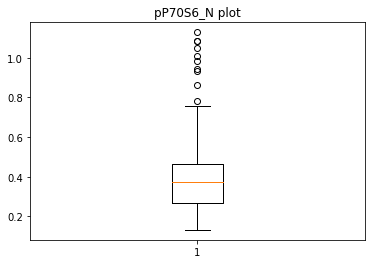


Mean :0.3788331686089239,  Max :0.131119792,  Min :0.131119792



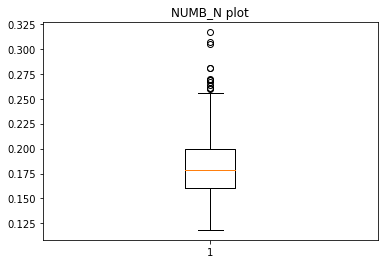


Mean :0.1817893104225722,  Max :0.118490967,  Min :0.118490967



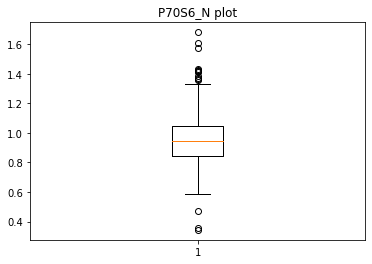


Mean :0.9494765087729659,  Max :0.344119778,  Min :0.344119778



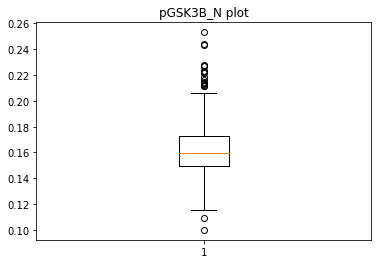


Mean :0.16169153555511812,  Max :0.099975851,  Min :0.099975851



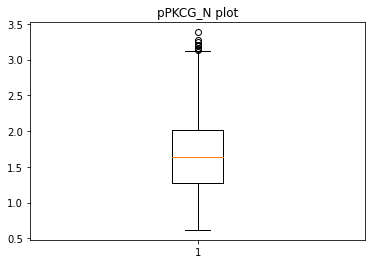


Mean :1.6659689254829397,  Max :0.617324673,  Min :0.617324673



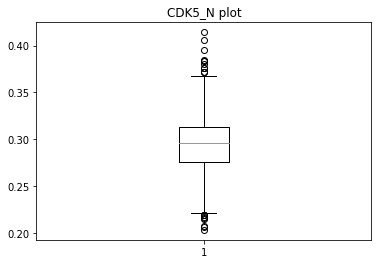


Mean :0.2940627164251969,  Max :0.203008321,  Min :0.203008321



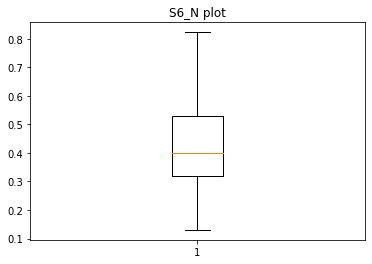


Mean :0.42678761662860887,  Max :0.130206306,  Min :0.130206306



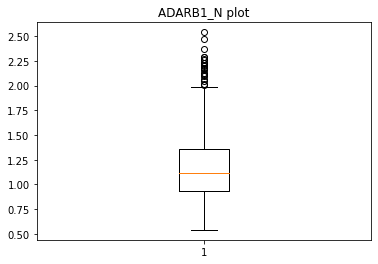


Mean :1.1779770728727033,  Max :0.538933813,  Min :0.538933813



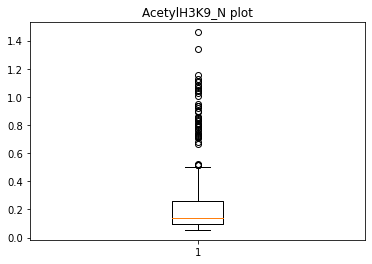


Mean :0.2117386499383202,  Max :0.054012868,  Min :0.054012868



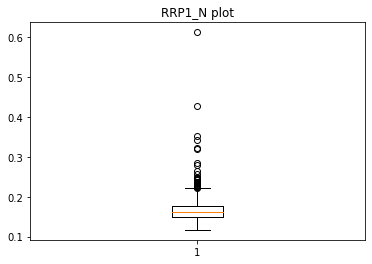


Mean :0.16678140270603675,  Max :0.116899744,  Min :0.116899744



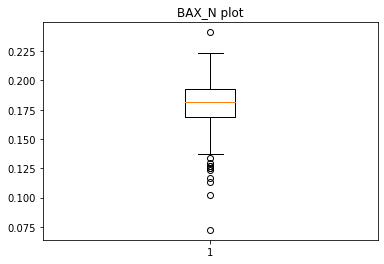


Mean :0.18001224507217847,  Max :0.072325525,  Min :0.072325525



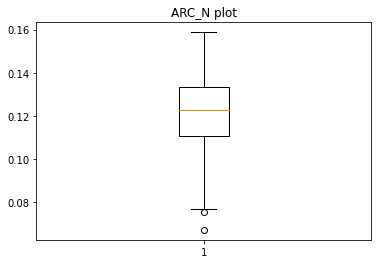


Mean :0.12209476892125984,  Max :0.067254286,  Min :0.067254286



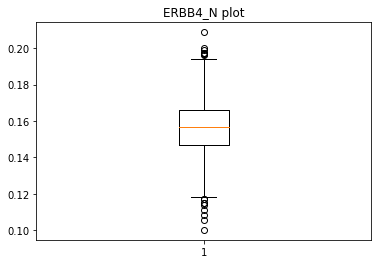


Mean :0.15655416818241472,  Max :0.100217339,  Min :0.100217339



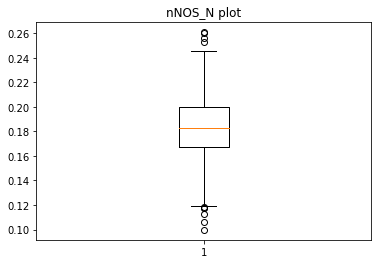


Mean :0.18200126499868766,  Max :0.099734364,  Min :0.099734364



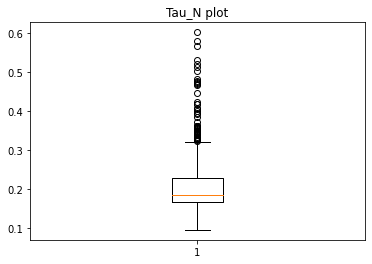


Mean :0.20887291873359579,  Max :0.096232794,  Min :0.096232794



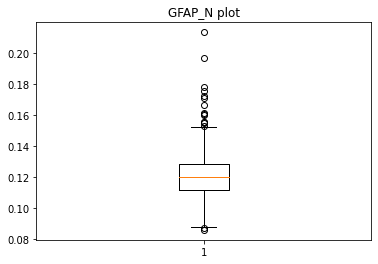


Mean :0.1210175901863517,  Max :0.08611418,  Min :0.08611418



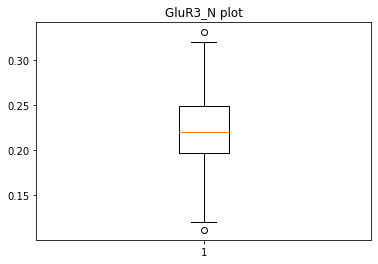


Mean :0.22448474016272965,  Max :0.111382114,  Min :0.111382114



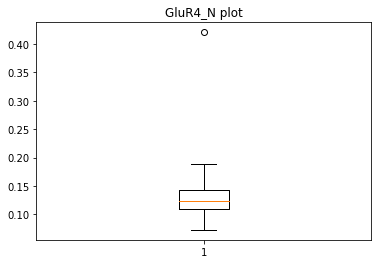


Mean :0.12673937785301836,  Max :0.072579682,  Min :0.072579682



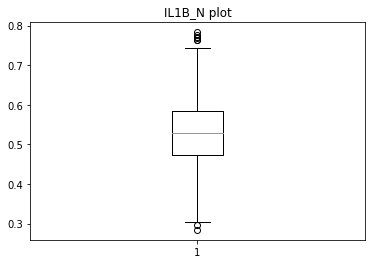


Mean :0.5290045696115486,  Max :0.284001296,  Min :0.284001296



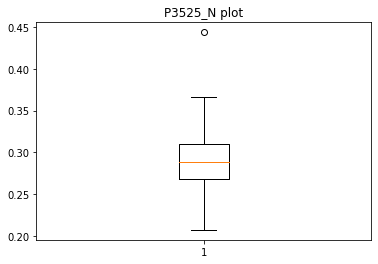


Mean :0.28923636582677165,  Max :0.207437817,  Min :0.207437817



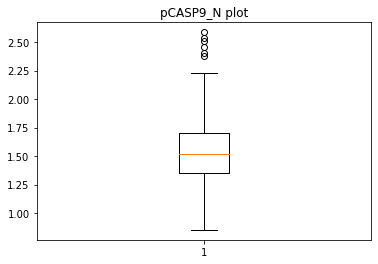


Mean :1.5334108382401574,  Max :0.853175561,  Min :0.853175561



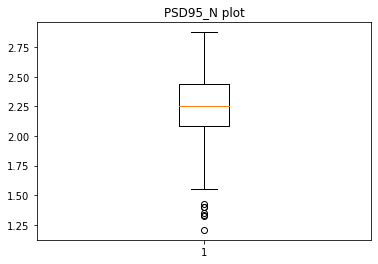


Mean :2.249525408211286,  Max :1.206097755,  Min :1.206097755



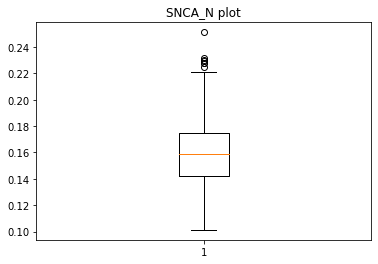


Mean :0.16020596272178478,  Max :0.101233152,  Min :0.101233152



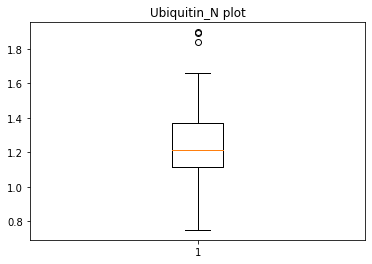


Mean :1.234310506891076,  Max :0.750664091,  Min :0.750664091



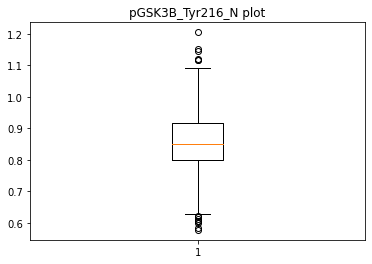


Mean :0.8467781004527558,  Max :0.577396764,  Min :0.577396764



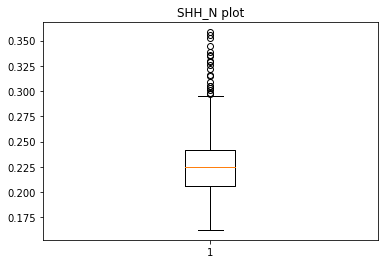


Mean :0.22636468512860897,  Max :0.162641874,  Min :0.162641874



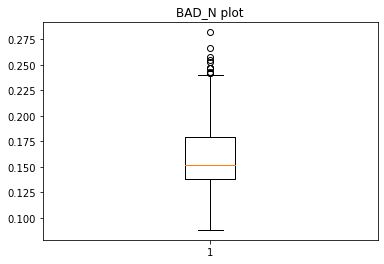


Mean :0.15977437160957478,  Max :0.088304624,  Min :0.088304624



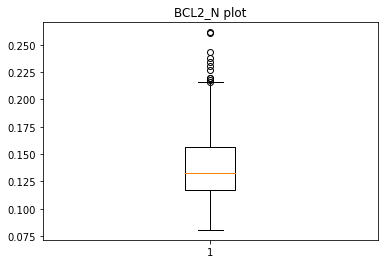


Mean :0.13932285864354718,  Max :0.080656846,  Min :0.080656846



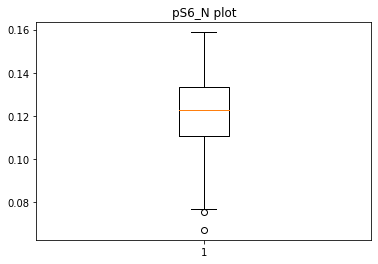


Mean :0.12209476892125984,  Max :0.067254286,  Min :0.067254286



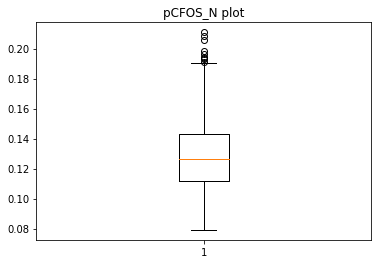


Mean :0.12950971579298104,  Max :0.07913246332039049,  Min :0.07913246332039049



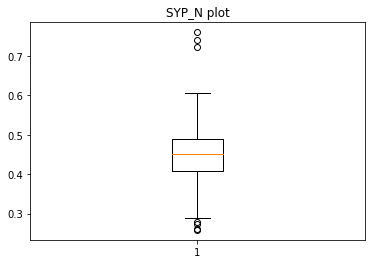


Mean :0.45025996293307086,  Max :0.258625833,  Min :0.258625833



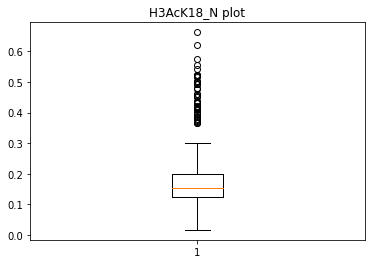


Mean :0.1756626036195307,  Max :0.016804961727389413,  Min :0.016804961727389413



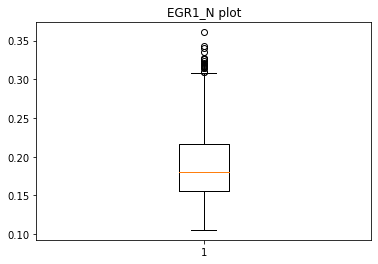


Mean :0.19070802040244642,  Max :0.105537204,  Min :0.105537204



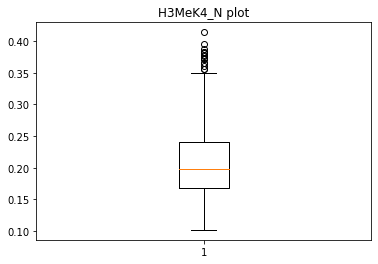


Mean :0.20989755073275101,  Max :0.101787008,  Min :0.101787008



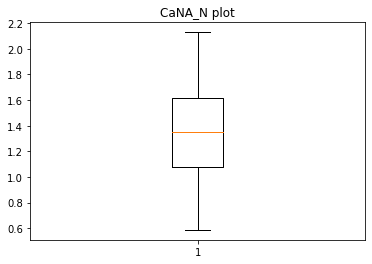


Mean :1.3579535543005252,  Max :0.586478779,  Min :0.586478779



In [116]:
arr = train_df.to_numpy()
mean_arr = np.mean(arr,axis=0)
max_arr = arr.min(axis=0)
min_arr = arr.min(axis=0)
c = 0 
for feature in train_df.columns.values:
  data = train_df[feature].to_numpy()
  # Creating plot
  plt.boxplot(data)
  # show plot
  plt.title(feature + " plot")
  plt.show()

  print()
  print ("Mean :"+str(mean_arr[c])+",  Max :"+str(max_arr[c])+",  Min :"+str(min_arr[c]))
  print()
  
  c = c + 1

Except a few most of the means seem to be concentrated between 0 and 1, rest eiter do not exist maybe due to undesired data in the dataframe, or are around 2 or 3.

The minimum values almost seem to be in the ranges of 0 to 1.

There is quite the variation in the maximum values in for the features. But, all seem to lie below 10 and more than 1.

## **Observations**
In essence:
1. The coloumns have diffent scales of data.
2. Means maximum and minimum might be neat but are not to be assumed same.
3. There are outliers but tehy are a few and the ranges are not that considerable enough to remove the data, since its we don't have much. Also after reffering to, https://www.quora.com/Is-it-reasonable-to-exclude-outliers-in-your-training-dataset-for-your-classifier , I came to theconclusion to keep them.

Thus we need to check their useability, correlation and balance.

In [117]:
import sklearn
from sklearn.feature_selection import r_regression
target_train_X = train_data_df.replace({'Genotype':{'Control':0, 'Ts65Dn':1}})['Genotype']
target_train_Y = train_data_df.replace({'Treatment_Behavior':{'Memantine_C/S':0, 'Memantine_S/C':1, 'Saline_C/S':2, 'Saline_S/C':3}})['Treatment_Behavior']

y = target_train_X.to_numpy()
t = target_train_Y.to_numpy()
z = sklearn.feature_selection.r_regression(arr, y, center=True)
k = sklearn.feature_selection.r_regression(arr, t, center=True)
print(z)
print(k)

# convert array into dataframe
#DF = pd.DataFrame(k)
  
# save the dataframe as a csv file
#DF.to_csv("data2.csv")

[ 0.07589482  0.17902464 -0.0400973  -0.09402298 -0.13859178  0.1607917
  0.06582603  0.03833524  0.20543193 -0.01504007  0.0095104   0.06750749
  0.06550904  0.12704934 -0.16675759 -0.12210983 -0.05849732  0.08248539
  0.20225708 -0.08483102  0.05142076  0.00635843  0.13798272 -0.07316194
 -0.08532088  0.04867783  0.08410578  0.09903838  0.15961491  0.10037853
  0.51801224 -0.02067815 -0.03291105 -0.24703904 -0.16234304 -0.14218811
  0.0433271  -0.18648996 -0.17600735 -0.07604859 -0.10553099  0.11737604
  0.12696588  0.12754732  0.08852251  0.07521524  0.27650339  0.09823577
  0.32481183 -0.04979196  0.19615171  0.01566343  0.09029348 -0.04214642
  0.07878348  0.10575391  0.22583271  0.00254385 -0.33336878 -0.13753034
 -0.06959831  0.09765353  0.04608054  0.09575102 -0.07068714  0.12011777
  0.10181356 -0.03006901 -0.0676515  -0.13698997 -0.04214642 -0.16686527
 -0.20245815  0.12753853 -0.14505545  0.02182528  0.08480998]
[-0.12318562 -0.10344669 -0.09352686  0.02830745 -0.05631379 -0

Features 31, 49, 59 exhibit more than 0.3 correlttion with classification in magnitude.

## Histogrms of the data (after imputation)

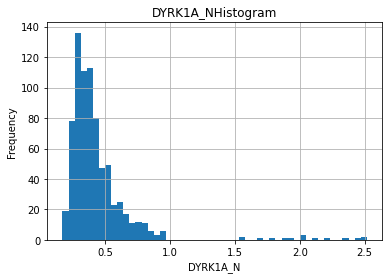

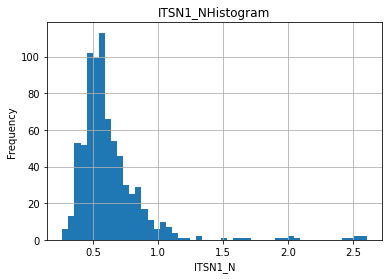

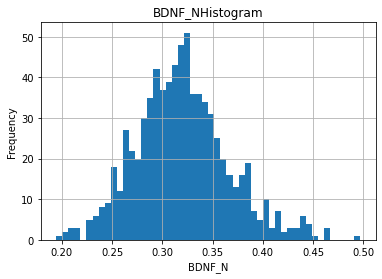

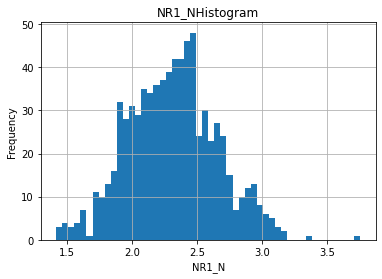

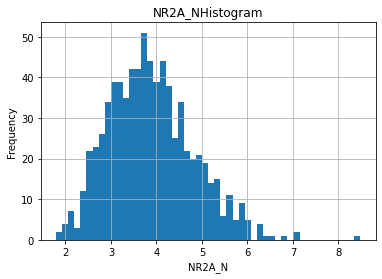

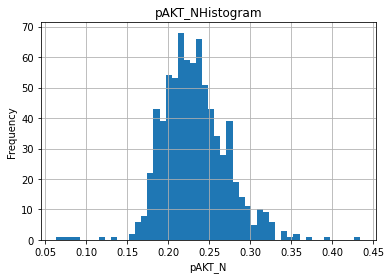

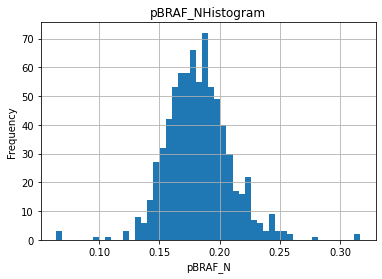

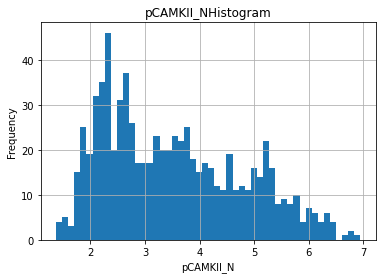

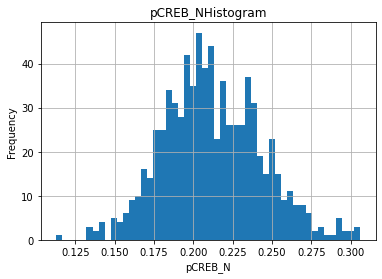

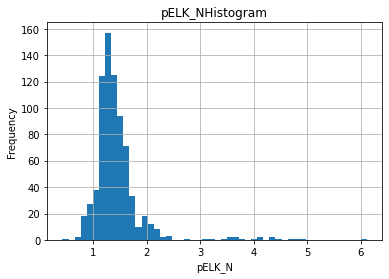

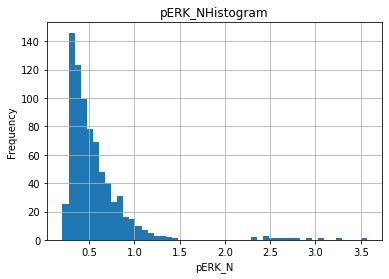

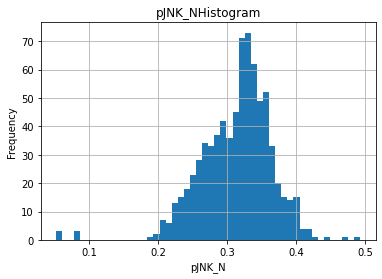

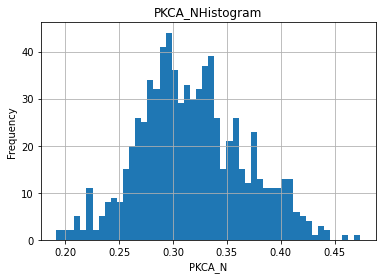

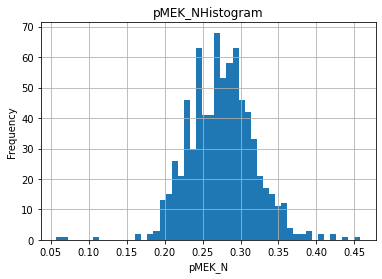

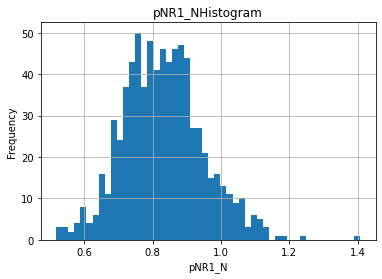

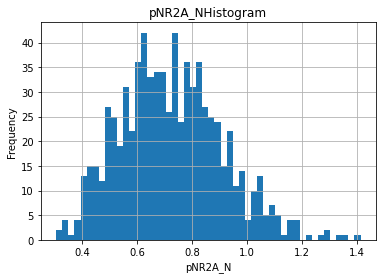

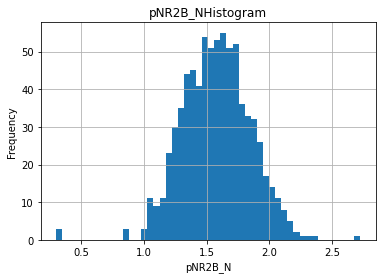

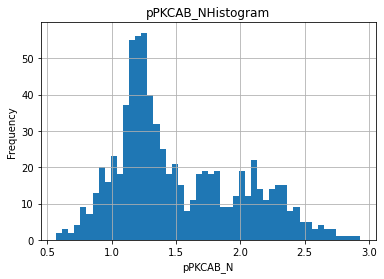

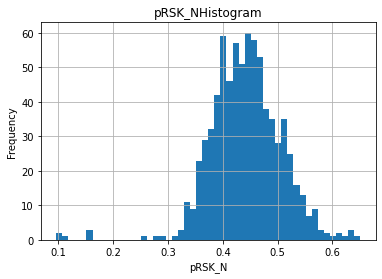

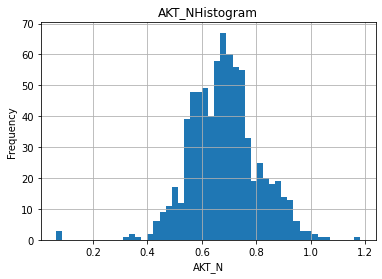

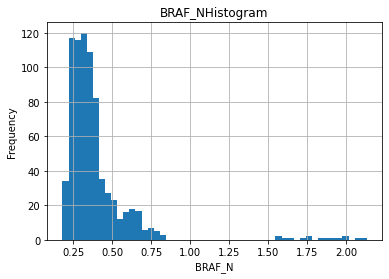

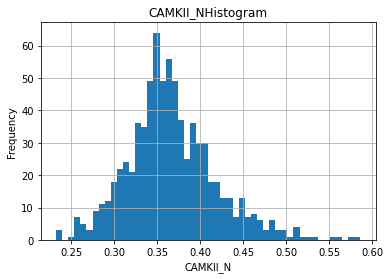

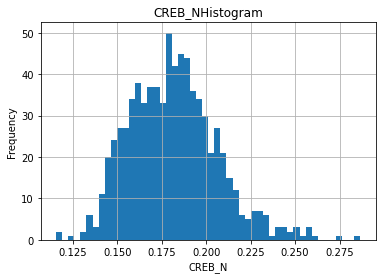

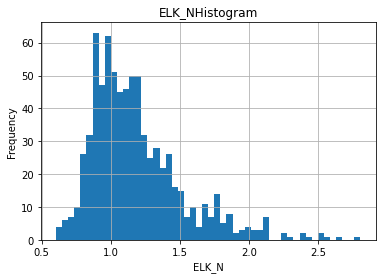

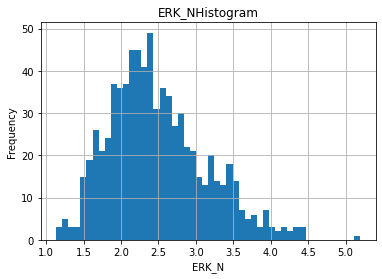

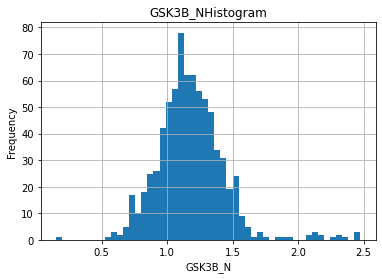

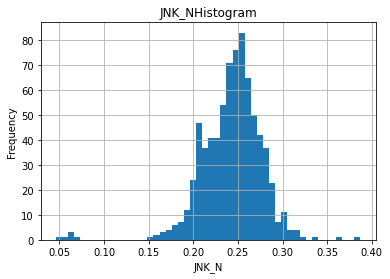

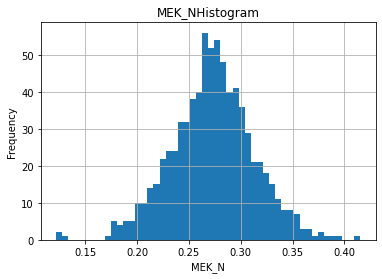

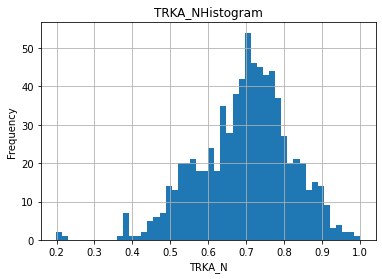

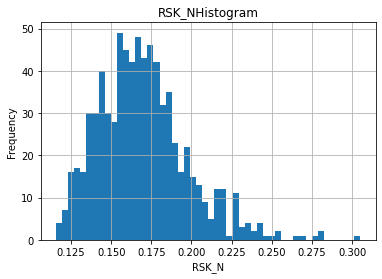

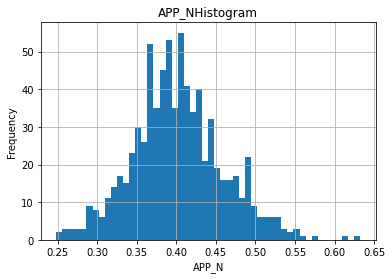

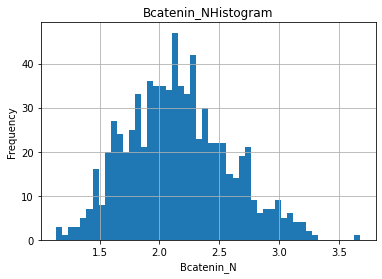

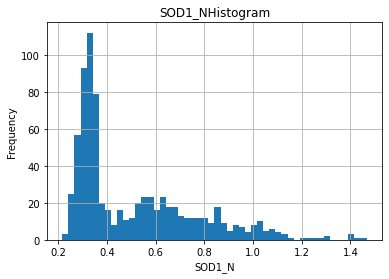

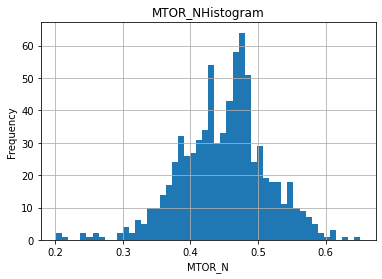

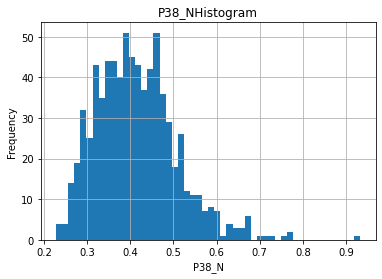

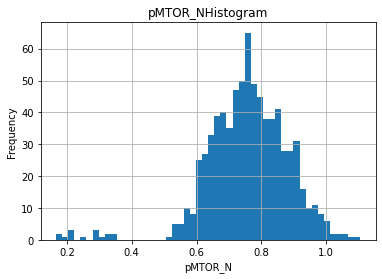

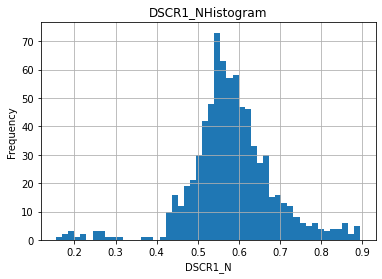

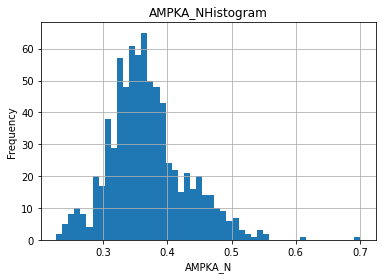

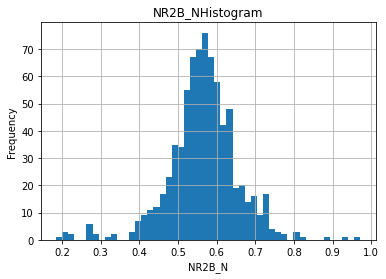

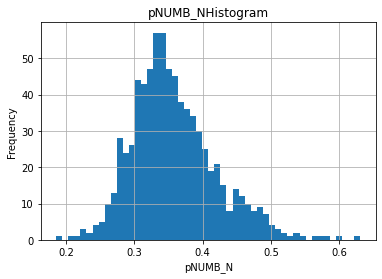

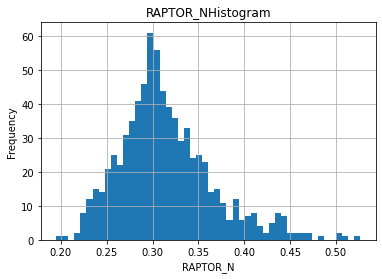

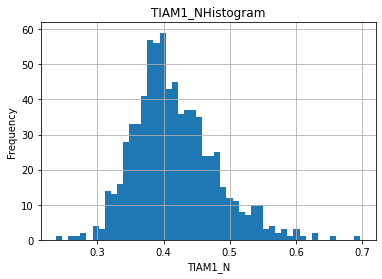

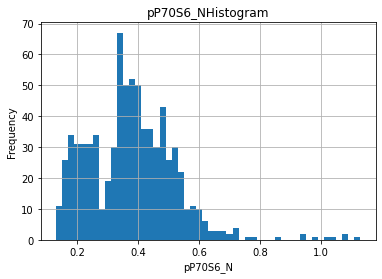

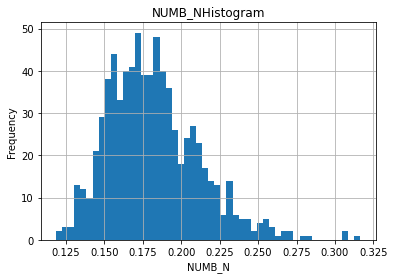

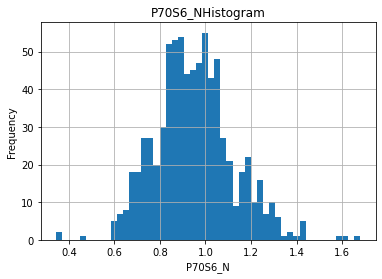

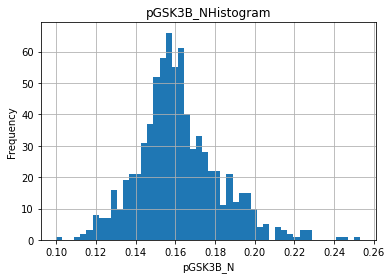

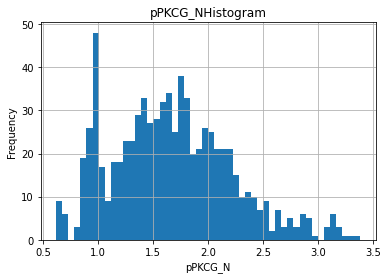

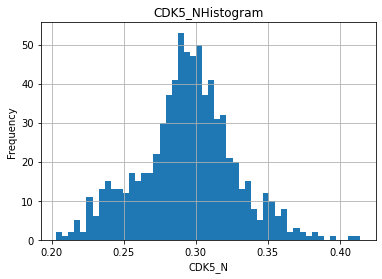

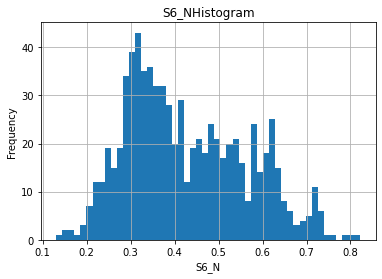

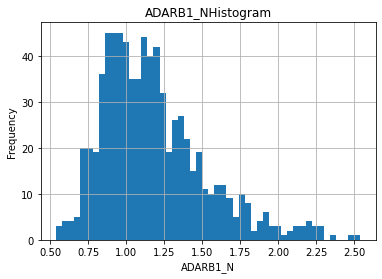

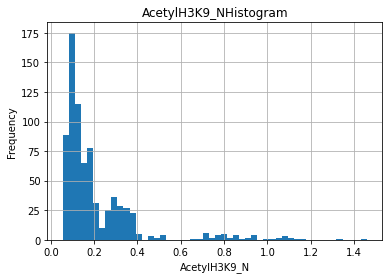

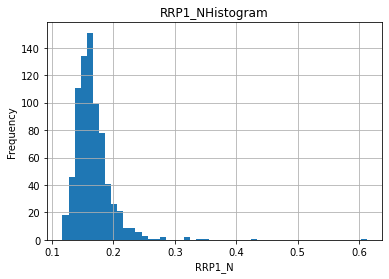

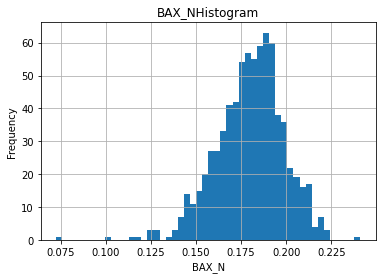

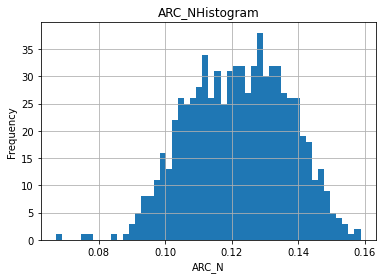

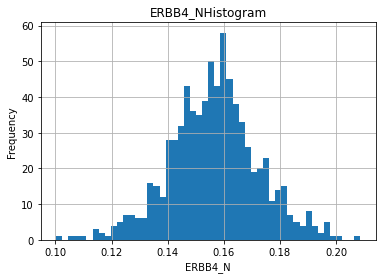

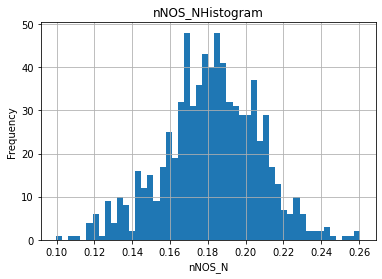

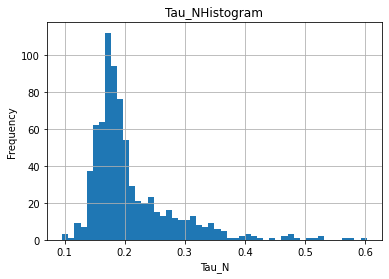

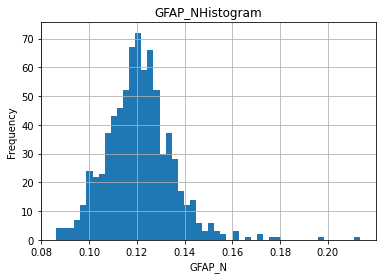

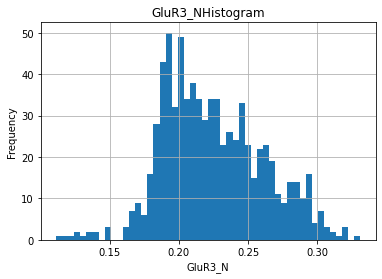

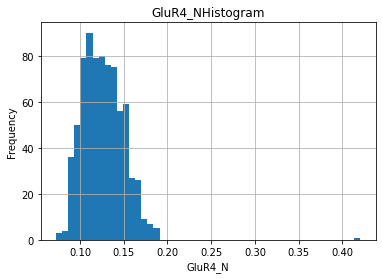

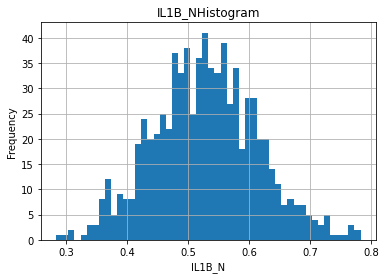

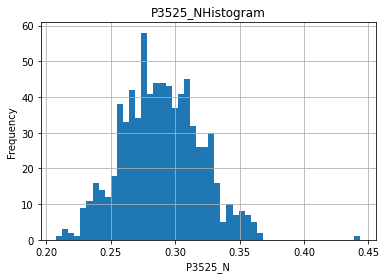

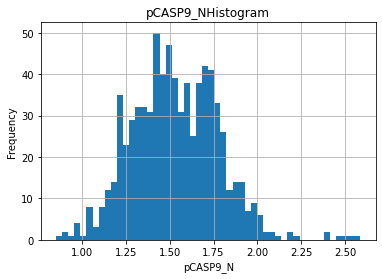

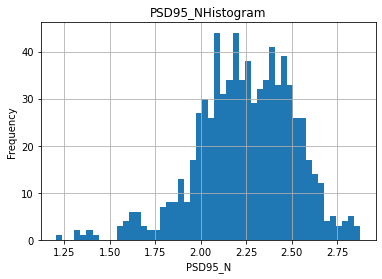

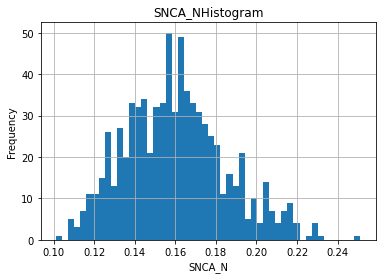

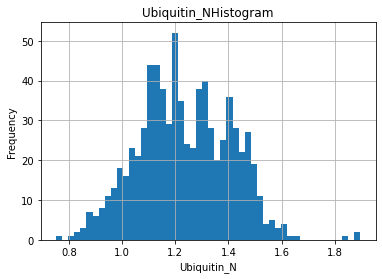

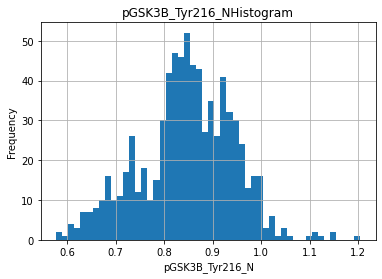

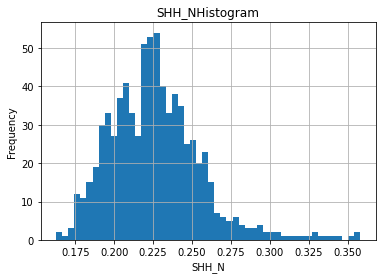

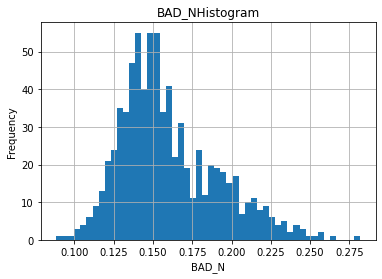

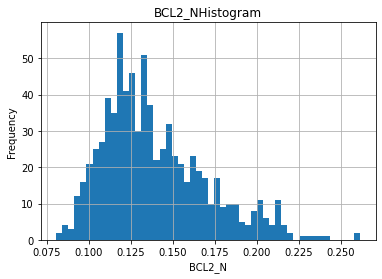

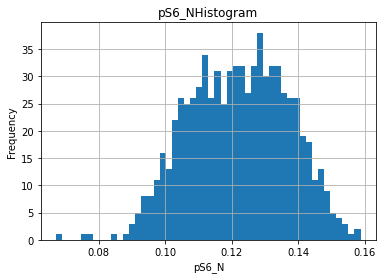

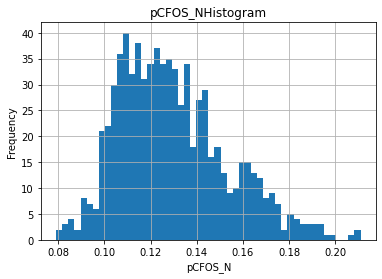

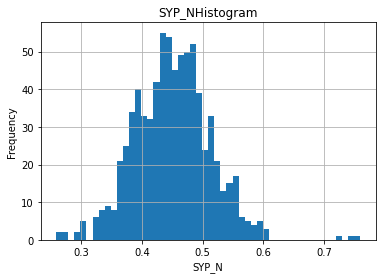

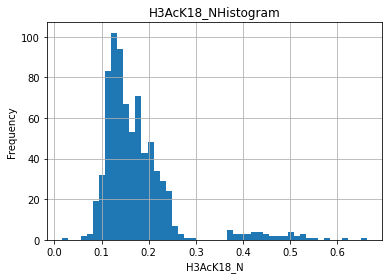

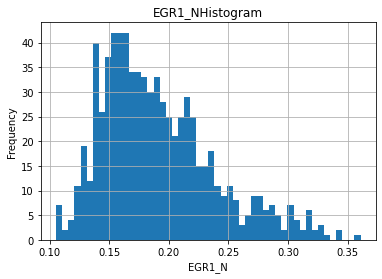

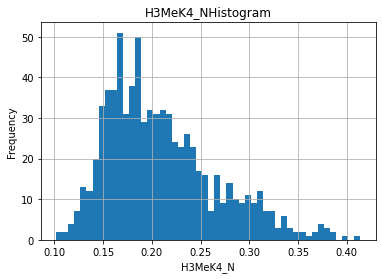

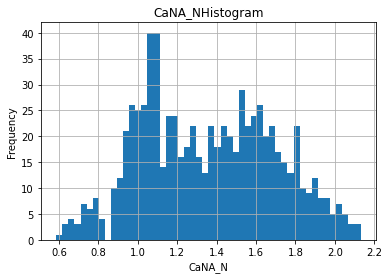

In [118]:
#To visualize the variables since all are continous we are creating histograms to understand their distribution
# So now taking all the features and checking their histograms

for feature in train_df.columns.values:
    # I chose bin size 50 since it helped me visialize the shape easier.
    train_df[feature].hist(bins=50)

    plt.xlabel(feature)
    plt.ylabel("Frequency")
    
    plt.title(feature + "Histogram")
    plt.show()

There are quite a few skewed data, which I will be dropping manually, along with the correlated features.

# The correlation heatmap (Pearson Correlation)

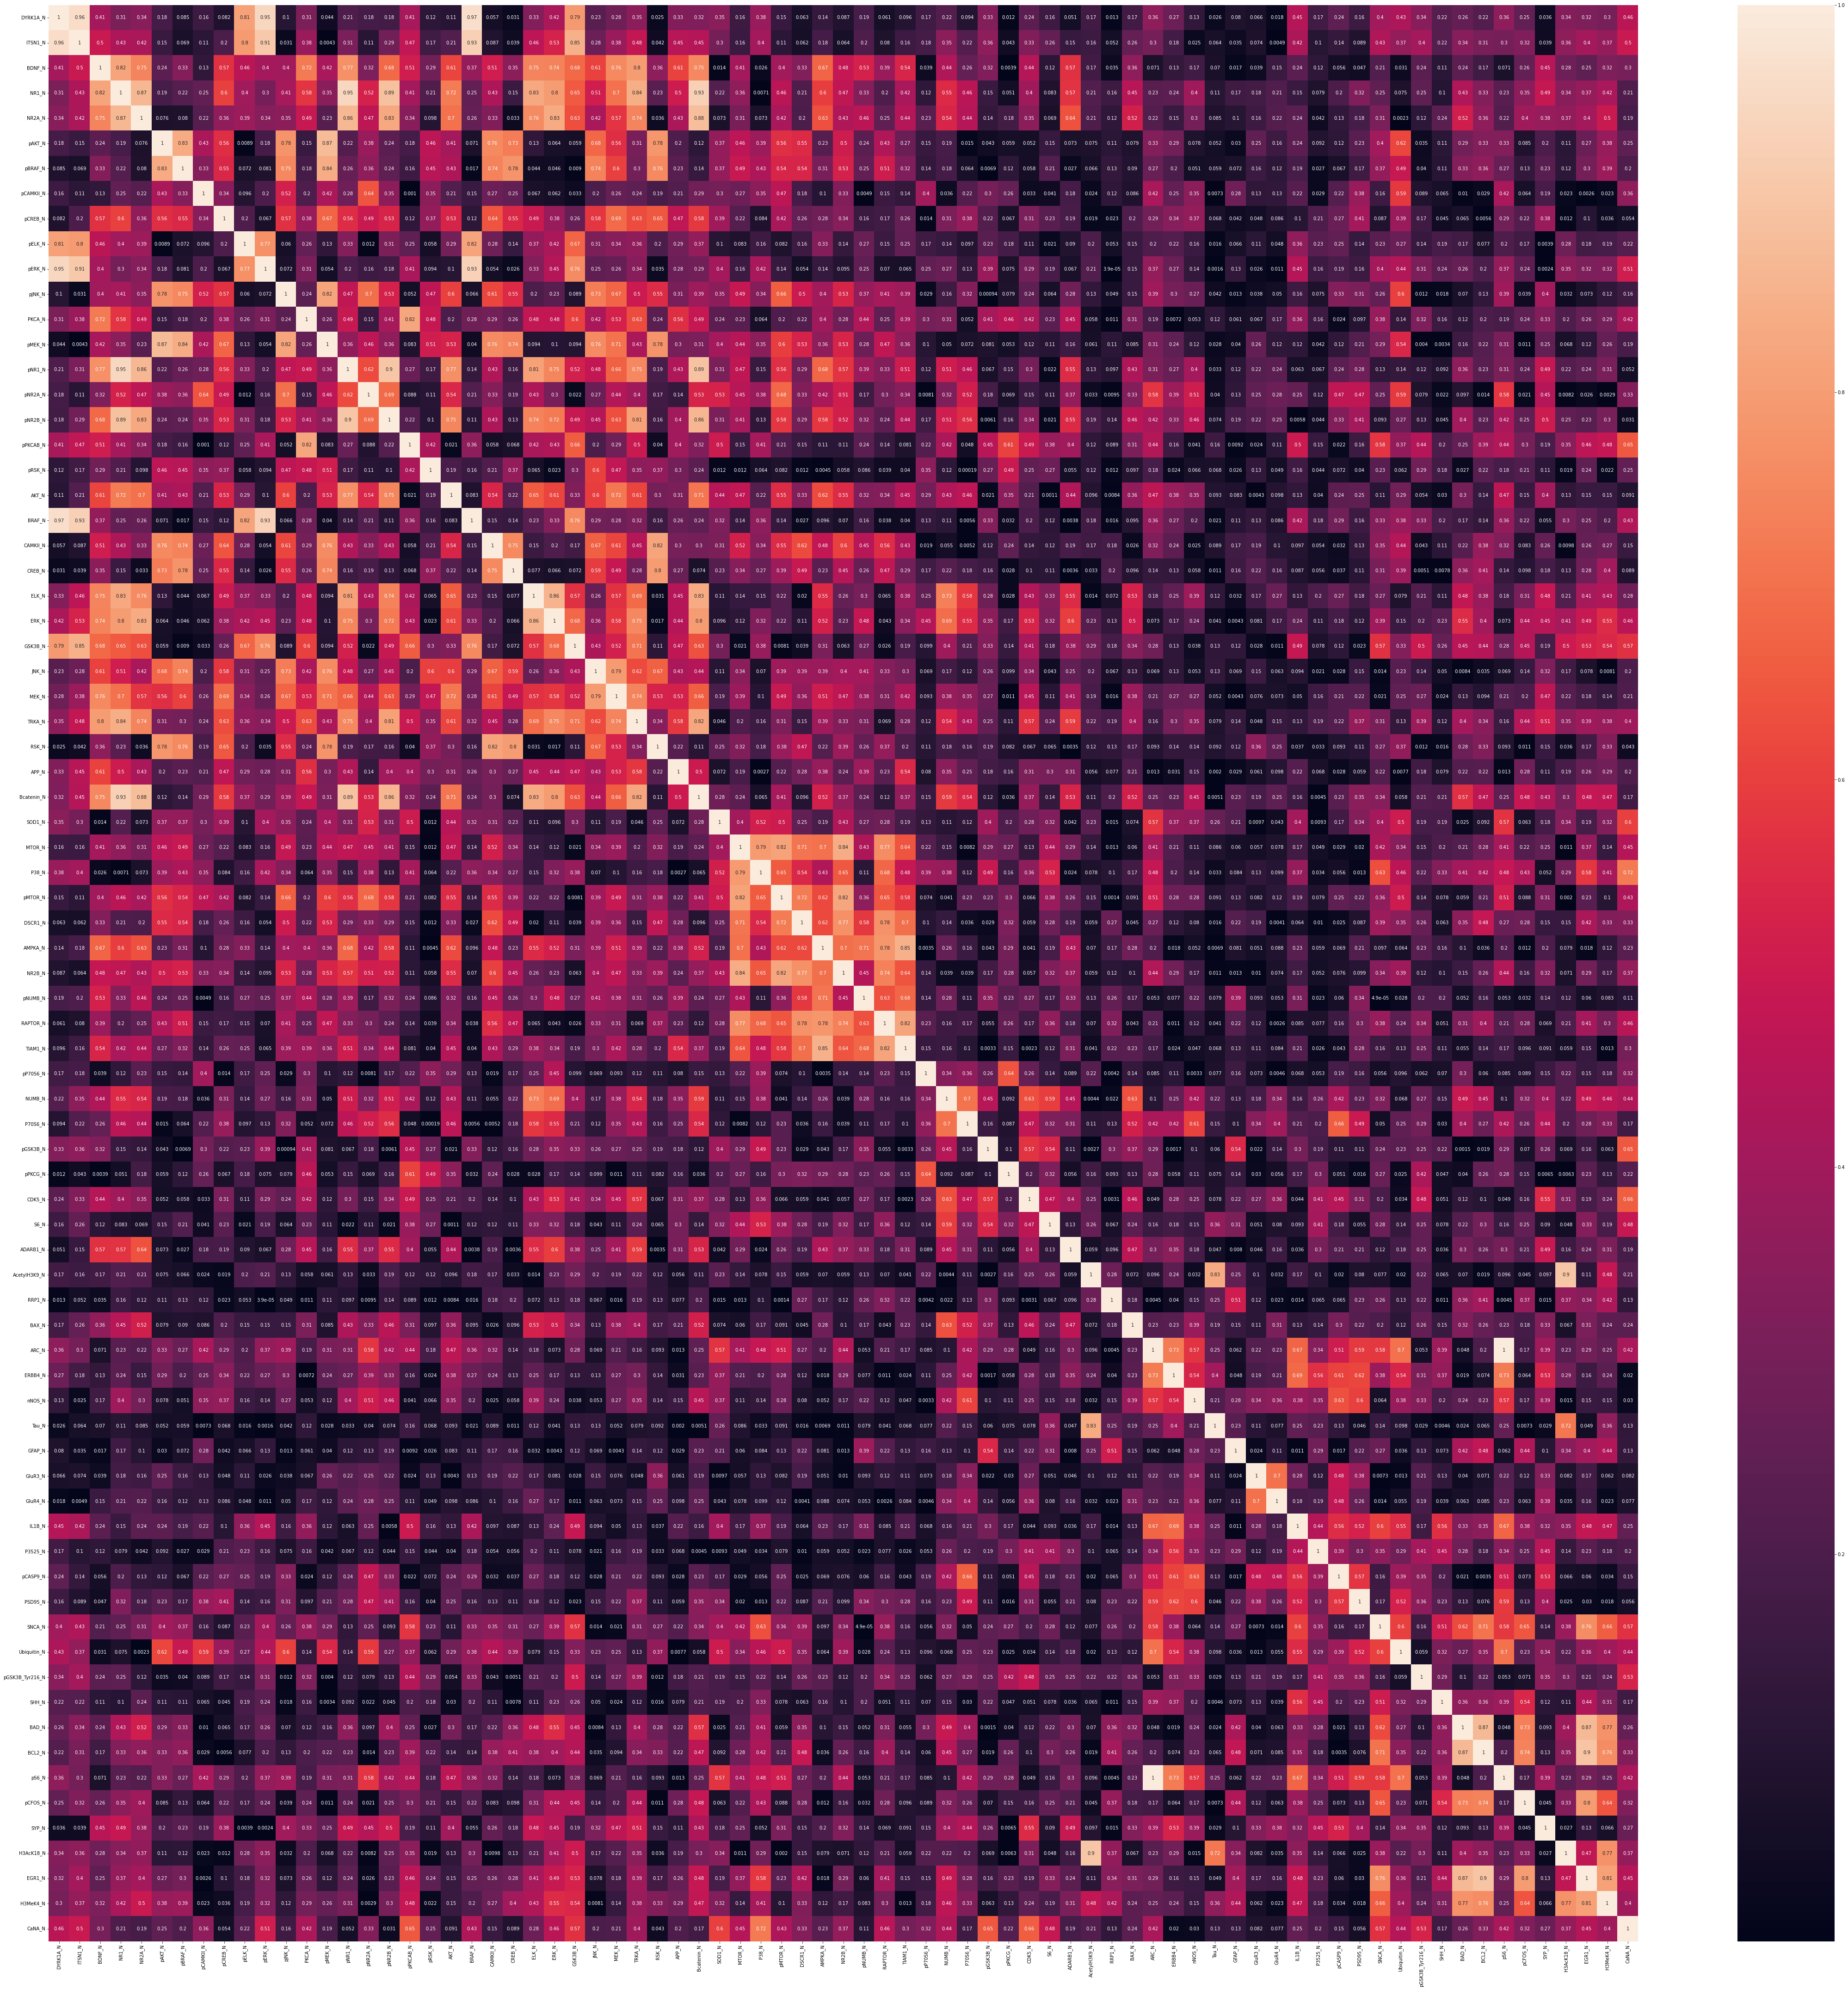

In [119]:
# So I'll be using the most commonly used correlation methon, Pearson's Correlation 
corr_pearson = train_df.corr(method= 'pearson')

#Now making a heatmap out of it.
fig, ax = plt.subplots(figsize=(77,77))
sns.heatmap(abs(corr_pearson), annot = True)
plt.show()

Its quite obvious some variables need to be dropped, there is a lot of highly correlated variables as seen by the peach colour indicating more than 0.8 correlation factor.

In [120]:
#corr_pearson.to_csv("Judge.csv")

After consulting the websites:

https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/

https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php

https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/

I came to the conclusion that:

1.0 - 0.7 : High Correlation

0.7 - 0.5 : Medium Correlation

0.5> : Low Correlation

So, I have listed some variables and their high correlation features, are:

1. **For DYRK1A_N** : ITSN1_N, pELK_N, pERK_N, BRAF_N, GSK3B_N.
2. **For BDNF_N** : NR1_N, NR2A_N, pCREB_N, PKCA_N, pNR1_N, pNR2B_N, PKCAB_N, AKT_N, CAMKII_N, ELK_N, ERK_N, JNK_N, MEK_N, TRKA_N, APP_N, Bcatenin_N, AMPKA_N, pNUMB_N, TIAM1_N, ADARB1_N.
3. **For pAKT_N** : pBRAF_N, pJNK_N, pMEK_N, CREB_N, RSK_N, pMTOR_N, DSCR1_N, NR2B_N, Ubiquitin_N.
4. **For pNR2A_N** : pCAMKII_N, SOD1_N, P70S6_N, ARC_N, nNOS_N, pS6_N.
5. **For MTOR_N** : P38_N, RAPTOR_N.
6. **For pP70S6_N** : pPKCG_N.
7. **For NUMB_N** : CDK5_N, S6_N, BAX_N.
8. **For pGSK3B_N** : GFAP_N, CaNA_N.
9. **For AcetylH3K9_N** : Tau_N, H3AcK18_N.
10. **For ERBB4_N** : IL1B_N, P3525_N, pCASP9_N, PSD95_N, SYP_N.
11. **For GluR3_N** : SHH_N, BAD_N, BCL2_N, pCFOS_N, EGR1_N, H3MeK4_N.

DO KEEP IN Mind there are more such relations, but since this list is formed after successive elimination of feautres based on high correlation, some data might not be listed.


   So, after consulting a few websites found out that 0.6 more or less is a good enough threshold to start dropping variables. So, I took the data in an excel sheet and conditionally marked the data having more than 0.6 correlation coefficient.


# We can use *KBestfeatures*, ANOVA and F-score based to list out the acceptible features available in sklearn package. Along with the observations above and correlation Heatmap. Seiving out ot best features. 

---

 

After consulting https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6532382/#:~:text=It%20may%20be%20wise%20to,statistically%20significant%20is%20clinically%20significant.

I came to the conclusion that for Biological data I can consider a p-value threshold of 0.001 to get a good result in false positive cases. 

There by I eneded up with 30 features satisfying this, and later on  manuallt selected the features after consultation with the correlation heatmap to form the training dataset.


##For the Binary Classfication.

In [121]:
# Explanation of wht K = 30 s given below after the histogram
sb1 =  SelectKBest(k=30)

# This is for the Binary classificatin so the function is set as shown
X_new =sb1.fit_transform(train_df, train_data_df['Genotype'])

In [122]:
list_names = sb1.feature_names_in_
dataset_101 = pd.DataFrame({'Feat': list_names, 'Scores': sb1.scores_, 'P value': sb1.pvalues_,}, columns=['Feat', 'Scores', 'P value'])
display(dataset_101)

Feat     Scores       P value
0    DYRK1A_N   4.402979  3.620574e-02
1     ITSN1_N  25.164377  6.559117e-07
2      BDNF_N   1.223890  2.689485e-01
3       NR1_N   6.778569  9.405912e-03
4      NR2A_N  14.883721  1.240449e-04
..        ...        ...           ...
72      SYP_N  32.483338  1.719988e-08
73  H3AcK18_N  12.566627  4.167231e-04
74     EGR1_N  16.334928  5.848004e-05
75   H3MeK4_N   0.362193  5.474703e-01
76     CaNA_N   5.506080  1.920640e-02

[77 rows x 3 columns]

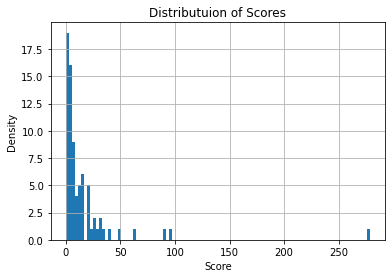

In [123]:
dist1 = pd.DataFrame(sb1.scores_)
dist1.hist(bins = 100)
plt.xlabel('Score')
plt.ylabel("Density")
plt.title("Distributuion of Scores")
plt.show()

Thus on all evidences I took features in descending orfer of scores upto 15.68 approx (for pMTOR_N) the 30th feature (Thus K = 30)as features below that have a p value more than 0.001.

## For the Multi-Class Classfication.

In [124]:
# Explanation of wht K =  s given below after the histogram
sb2 =  SelectKBest(k=30)

# This is for the Binary classificatin so the function is set as shown
X_new =sb2.fit_transform(train_df, train_data_df['Treatment_Behavior'])

In [125]:
list_names = sb1.feature_names_in_
dataset_101 = pd.DataFrame({'Feat': list_names, 'Scores': sb1.scores_, 'P value': sb1.pvalues_,}, columns=['Feat', 'Scores', 'P value'])
display(dataset_101)
#Using this dataframe in interactive dsplay in Google Colab I foud the values with p score below 0.001 

Feat     Scores       P value
0    DYRK1A_N   4.402979  3.620574e-02
1     ITSN1_N  25.164377  6.559117e-07
2      BDNF_N   1.223890  2.689485e-01
3       NR1_N   6.778569  9.405912e-03
4      NR2A_N  14.883721  1.240449e-04
..        ...        ...           ...
72      SYP_N  32.483338  1.719988e-08
73  H3AcK18_N  12.566627  4.167231e-04
74     EGR1_N  16.334928  5.848004e-05
75   H3MeK4_N   0.362193  5.474703e-01
76     CaNA_N   5.506080  1.920640e-02

[77 rows x 3 columns]

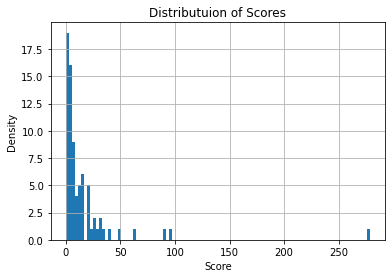

In [126]:
dist2 = pd.DataFrame(sb1.scores_)
dist2.hist(bins = 100)
plt.xlabel('Score')
plt.ylabel("Density")
plt.title("Distributuion of Scores")
plt.show()

# We are going to use these feaures in the dataset for our classification problem. 



---



In [127]:
# This is the features I decided using the Kbestfeatures and correlation heatmap
reduced_dataset_df = train_df[['ITSN1_N','NR2A_N','pAKT_N','pCREB_N','pMEK_N','pNR1_N','pNR2A_N','pRSK_N','CREB_N','TRKA_N','APP_N','MTOR_N','P38_N' ,'pMTOR_N' , 'AMPKA_N', 'NR2B_N', 'pP70S6_N','NUMB_N' , 'pPKCG_N', 'S6_N', 'AcetylH3K9_N', 'Tau_N','GluR3_N' ,'GluR4_N','Ubiquitin_N' , 'BCL2_N','pCFOS_N' ,'SYP_N' , 'H3AcK18_N', 'EGR1_N']]
display(reduced_dataset_df.shape)

(762, 30)

This is just a cross check on my feature selection, its not used later on as such.

# Training and Implementation and validation of the models.

---



## The Binary Classification 

---




### Splitting and Prepping the dataset and Binary targets.

In [128]:
# dividing the Given data to training and testing in 80% - 20% ratio 

# For data normalization
ss = preprocessing.StandardScaler() 
scaled_X = pd.DataFrame(ss.fit_transform(reduced_dataset_df))

# encoding the target values as 0,1
target_train1 = train_data_df.replace({'Genotype':{'Control':0, 'Ts65Dn':1}})['Genotype']

X_train, X_test, y_train, y_test = train_test_split( scaled_X.to_numpy(), target_train1.to_numpy(), test_size=0.20, random_state=10)

### Elastic Net Logistic Regression

In [129]:
# instantiating the classifier with default hyperparameters
elasNet_clf1 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)

# Define Parameters
params_el = [ {'penalty':['elasticnet'], 'solver': ['saga'], 'l1_ratio': [ 0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'C':[0.01, 0.1, 1.0, 10.0, 100.0]}]

# declaring the parameters for hyperparameter tuning
grid_search_el1 = GridSearchCV(estimator = elasNet_clf1, param_grid = params_el, scoring = 'accuracy', cv = 5, verbose=1)
grid_results_el1 = grid_search_el1.fit(X_train, y_train)

# To clear out the unnecassary computation
clear_output()

# The Best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_el1.best_score_))

# The parameters that give the best results
print('Parameters that give the best results : '+ str(grid_results_el1.best_params_))

# The estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search : '+ str(grid_results_el1.best_estimator_))

print ()
# calculate result score on test set
print('GridSearch CV score on test set: '+ str(grid_results_el1.score(X_test, y_test)))

y_pred_el1 = grid_results_el1.predict(X_test)

print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test,y_pred_el1))
print()
print (classification_report(y_test,y_pred_el1))

GridSearch CV best score : 0.9392629724969517
Parameters that give the best results : {'C': 1.0, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}
Estimator that was chosen by the search : LogisticRegression(l1_ratio=1.0, penalty='elasticnet', solver='saga')

GridSearch CV score on test set: 0.9281045751633987

The Confusion Matrix
[[86  4]
 [ 7 56]]

              precision    recall  f1-score   support

           0       0.92      0.96      0.94        90
           1       0.93      0.89      0.91        63

    accuracy                           0.93       153
   macro avg       0.93      0.92      0.93       153
weighted avg       0.93      0.93      0.93       153



### Neural network

In [130]:
# instantiating the classifier with default hyperparameters
nn_classifier1 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

# Define Parameters
params_nn = [ {'hidden_layer_sizes':[[1,], [10,], [50,], [100,]], 'activation':['relu'], 'solver': ['lbfgs'], 'alpha': [0.001,0.001,0.01,0.1,1.0]}]

# declaring the parameters for hyperparameter tuning
grid_search_nn1 = GridSearchCV(estimator = nn_classifier1, param_grid = params_nn, scoring = 'accuracy', cv = 5, verbose=0)
grid_results_nn1 = grid_search_nn1.fit(X_train, y_train)

#So, since a lot of unwanted processing information is displayed I cleared them out.
clear_output()

# The Best model

# THe best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_nn1.best_score_))

# The parameters that give the best results
print('Parameters that give the best results :'+ str (grid_results_nn1.best_params_))

# The estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str (grid_results_nn1.best_estimator_))

print ()
# calculate result score on test set
print('GridSearch CV score on test set: '+ str(grid_results_nn1.score(X_test, y_test)))

y_pred_nn1 = grid_results_nn1.predict(X_test)

print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test,y_pred_nn1))
print()
print (classification_report(y_test,y_pred_nn1))

GridSearch CV best score : 0.9901639344262296
Parameters that give the best results :{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': [100], 'solver': 'lbfgs'}
Estimator that was chosen by the search :MLPClassifier(alpha=0.1, hidden_layer_sizes=[100], random_state=1,
              solver='lbfgs')

GridSearch CV score on test set: 0.9934640522875817

The Confusion Matrix
[[89  1]
 [ 0 63]]

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        90
           1       0.98      1.00      0.99        63

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



###  SVM

In [131]:

# instantiating the classifier with default hyperparameters
svc_classifier1 = SVC() 

# Define Parameters
params_svc = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']}, {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}, {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]}]

# declaring the parameters for hyperparameter tuning
grid_search_svc1 = GridSearchCV(estimator = svc_classifier1, param_grid = params_svc, scoring = 'accuracy', cv = 5, verbose=0)
grid_results_svc1 = grid_search_svc1.fit(X_train, y_train)

# The Best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_svc1.best_score_))

# print parameters that give the best results
print('Parameters that give the best results :'+ str (grid_results_svc1.best_params_))

# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str (grid_results_svc1.best_estimator_))

print ()
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: '+str(grid_results_svc1.score(X_test, y_test)))

y_pred_svc1 = grid_results_svc1.predict(X_test)

print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test,y_pred_svc1))
print()
print (classification_report(y_test,y_pred_svc1))

GridSearch CV best score : 0.9917897303888361
Parameters that give the best results :{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Estimator that was chosen by the search :SVC(C=10, gamma=0.1)

GridSearch CV score on test set: 1.0

The Confusion Matrix
[[90  0]
 [ 0 63]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00        63

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



### Random forest 

In [132]:
# instantiating the classifier with default hyperparameters
rf_classifier1 = RandomForestClassifier()

# Define Parameters
params_rf = [{'max_depth':[1, 5, 10, 20, 50], 'n_estimators':[8, 16, 32, 64, 128, 256]}]

# Building the grid search
grid_search_rf1 = GridSearchCV(estimator=rf_classifier1, param_grid=params_rf, cv = 5)
grid_results_rf1 = grid_search_rf1.fit(X_train, y_train)


# The Best Model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_rf1.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :'+ str (grid_results_rf1.best_params_))
# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str (grid_results_rf1.best_estimator_))

print ()
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: '+ str(grid_results_rf1.score(X_test, y_test)))

y_pred_rf1 = grid_results_rf1.predict(X_test)

print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test,y_pred_rf1))
print()
print (classification_report(y_test,y_pred_rf1))

GridSearch CV best score : 0.9654924806936729
Parameters that give the best results :{'max_depth': 50, 'n_estimators': 64}
Estimator that was chosen by the search :RandomForestClassifier(max_depth=50, n_estimators=64)

GridSearch CV score on test set: 0.9869281045751634

The Confusion Matrix
[[90  0]
 [ 2 61]]

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        90
           1       1.00      0.97      0.98        63

    accuracy                           0.99       153
   macro avg       0.99      0.98      0.99       153
weighted avg       0.99      0.99      0.99       153



## Thus we see all the Models giving brilliant results with SVC the best (perfect scores), followed by Neural Networks (Acc = 0.99 and recall = 0.99), then Random forest with a slightly low recall of 0.98 and lastly Elastic Net Logistic reggression. 

## The Muti-Class Classification.

---



###Splitting and Prepping the dataset and Multi targets.

In [133]:
# dividing the Given data to training and testing in 80% - 20% ratio 
 # For data normalization
ss = preprocessing.StandardScaler()
# normalize data

ss.fit(reduced_dataset_df)
scaled_X = pd.DataFrame(ss.transform(reduced_dataset_df))

# encoding the target values as 0,1
# Ref:https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.replace.html
target_train2 = train_data_df.replace({'Treatment_Behavior':{'Memantine_C/S':0.0, 'Memantine_S/C':1.0, 'Saline_C/S':2.0, 'Saline_S/C':3.0}})['Treatment_Behavior']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split( scaled_X.to_numpy(), target_train2.to_numpy(), test_size=0.20, random_state=42)

###Elastic Net Logistic Reggression

In [134]:
# instantiating the classifier with default hyperparameters
elasNet_clf2 = LogisticRegression(penalty = 'elasticnet', solver = 'saga', l1_ratio = 0.5)

# Define Parameters
params_el = [ {'penalty':['elasticnet'], 'solver': ['saga'], 'l1_ratio': [ 0.0, 0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], 'C':[0.01, 0.1, 1.0, 10.0, 100.0]}]

# declaring the parameters for hyperparameter tuning
grid_search_el2 = GridSearchCV(estimator = elasNet_clf2, param_grid = params_el, scoring = 'accuracy', cv = 5)
grid_results_el2 = grid_search_el2.fit(X_train_2, y_train_2)

#So, since a lot of unwanted processing information is displayed I cleared them out.
clear_output()

# The Best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_el2.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :'+ str(grid_results_el2.best_params_))
# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str(grid_results_el2.best_estimator_))
print ()
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: '+ str(grid_results_el2.score(X_test_2, y_test_2)))

y_pred_en2 = grid_results_el2.predict(X_test_2)

print()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test_2,y_pred_en2))
print()
print (classification_report(y_test_2,y_pred_en2))

GridSearch CV best score : 0.9309714130876575
Parameters that give the best results :{'C': 1.0, 'l1_ratio': 1.0, 'penalty': 'elasticnet', 'solver': 'saga'}
Estimator that was chosen by the search :LogisticRegression(l1_ratio=1.0, penalty='elasticnet', solver='saga')

GridSearch CV score on test set: 0.9019607843137255

The Confusion Matrix
[[41  0  6  1]
 [ 0 38  0  0]
 [ 7  0 27  0]
 [ 0  1  0 32]]

              precision    recall  f1-score   support

         0.0       0.85      0.85      0.85        48
         1.0       0.97      1.00      0.99        38
         2.0       0.82      0.79      0.81        34
         3.0       0.97      0.97      0.97        33

    accuracy                           0.90       153
   macro avg       0.90      0.90      0.90       153
weighted avg       0.90      0.90      0.90       153



### Neural Network

In [135]:
# instantiating the classifier with default hyperparameters
nn_classifier2 = MLPClassifier()

# Define Parameters
parameters = [ {'hidden_layer_sizes':[[1,], [10,], [50,], [100,]], 'activation':['relu'], 'solver': ['lbfgs'], 'alpha': [0.001,0.001,0.01,0.1,1.0]}]

# declaring the parameters for hyperparameter tuning
grid_search_nn2 = GridSearchCV(estimator = nn_classifier2, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=0)
grid_results_nn2 = grid_search_nn2.fit(X_train_2, y_train_2)

#So, since a lot of unwanted processing information is displayed I cleared them out.
clear_output()

# The best model
# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_nn2.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :'+ str(grid_results_nn2.best_params_))
# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str(grid_results_nn2.best_estimator_))

print ()
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: '+ str(grid_results_nn2.score(X_test_2, y_test_2)))

y_pred_nn2 = grid_results_nn2.predict(X_test_2)

print()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test_2,y_pred_nn2))
print()
print (classification_report(y_test_2,y_pred_nn2))

GridSearch CV best score : 0.9934426229508198
Parameters that give the best results :{'activation': 'relu', 'alpha': 0.1, 'hidden_layer_sizes': [50], 'solver': 'lbfgs'}
Estimator that was chosen by the search :MLPClassifier(alpha=0.1, hidden_layer_sizes=[50], solver='lbfgs')

GridSearch CV score on test set: 0.9934640522875817

The Confusion Matrix
[[48  0  0  0]
 [ 0 38  0  0]
 [ 1  0 33  0]
 [ 0  0  0 33]]

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        48
         1.0       1.00      1.00      1.00        38
         2.0       1.00      0.97      0.99        34
         3.0       1.00      1.00      1.00        33

    accuracy                           0.99       153
   macro avg       0.99      0.99      0.99       153
weighted avg       0.99      0.99      0.99       153



### SVM

In [136]:
# instantiating classifier with default hyperparameters
svc_classifier2 = SVC() 

# declaring parameters for hyperparameter tuning
parameters = [ {'C':[1, 10, 100, 1000], 'kernel':['linear']}, {'C':[1, 10, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}, {'C':[1, 10, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]}]

#setting the grid search
grid_search_svc2 = GridSearchCV(estimator = svc_classifier2, param_grid = parameters, scoring = 'accuracy', cv = 5, verbose=0)
grid_result_svc2 = grid_search_svc2.fit(X_train_2, y_train_2)

# The Best Model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_result_svc2.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :'+ str(grid_result_svc2.best_params_))
# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str(grid_result_svc2.best_estimator_))

# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: '+ str(grid_result_svc2.score(X_test_2, y_test_2)))

y_pred_svc2 = grid_result_svc2.predict(X_test_2)

print()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test_2,y_pred_svc2))
print()
print (classification_report(y_test_2,y_pred_svc2))

GridSearch CV best score : 0.9868446010025742
Parameters that give the best results :{'C': 10, 'degree': 3, 'gamma': 0.05, 'kernel': 'poly'}
Estimator that was chosen by the search :SVC(C=10, gamma=0.05, kernel='poly')
GridSearch CV score on test set: 1.0

The Confusion Matrix
[[48  0  0  0]
 [ 0 38  0  0]
 [ 0  0 34  0]
 [ 0  0  0 33]]

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        48
         1.0       1.00      1.00      1.00        38
         2.0       1.00      1.00      1.00        34
         3.0       1.00      1.00      1.00        33

    accuracy                           1.00       153
   macro avg       1.00      1.00      1.00       153
weighted avg       1.00      1.00      1.00       153



### Random Forest

In [137]:
# Define Parameters
params_rf2 = [{'max_depth':[1, 5, 10, 20, 50], 'n_estimators':[8, 16, 32, 64, 128, 256]}]

#instantiating the classifier
rf_classifier2 = RandomForestClassifier()

# Build the grid search
grid_search_rf2 = GridSearchCV(estimator=rf_classifier2, param_grid=params_rf2, cv = 5)
grid_results_rf2 = grid_search_rf2.fit(X_train_2, y_train_2)


# The Best model

# best score achieved during the GridSearchCV
print('GridSearch CV best score : '+ str(grid_results_rf2.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :'+ str(grid_results_rf2.best_params_))
# print estimator that was chosen by the GridSearch
print('Estimator that was chosen by the search :'+ str(grid_results_rf2.best_estimator_))

# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: '+ str(grid_results_rf2.score(X_test_2, y_test_2)))

y_pred_rf2 = grid_results_rf2.predict(X_test_2)

print()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(y_test_2,y_pred_rf2))
print()
print (classification_report(y_test_2,y_pred_rf2))

GridSearch CV best score : 0.9638531364313778
Parameters that give the best results :{'max_depth': 50, 'n_estimators': 128}
Estimator that was chosen by the search :RandomForestClassifier(max_depth=50, n_estimators=128)
GridSearch CV score on test set: 0.9738562091503268

The Confusion Matrix
[[48  0  0  0]
 [ 0 38  0  0]
 [ 1  0 33  0]
 [ 0  2  1 30]]

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        48
         1.0       0.95      1.00      0.97        38
         2.0       0.97      0.97      0.97        34
         3.0       1.00      0.91      0.95        33

    accuracy                           0.97       153
   macro avg       0.98      0.97      0.97       153
weighted avg       0.97      0.97      0.97       153



## Thus we see all the Models giving brilliant results again with SVC the best (perfect scores), followed by Neural Networks (Acc = 0.99 and recall = 0.99), then Random forest with a slightly low recall of 0.97 and lastly Elastic Net Logistic reggression. 

## Validation using the validation dataset

---



In [138]:
# encoding the target values for 'Genotype' class as 0,1
target1_df = val_data_df.replace({'Genotype':{'Control':0, 'Ts65Dn':1}})['Genotype']
target1 = target1_df.to_numpy()

# encoding the target values for 'Treatment_Behavior' class as 0,1,2,3
target2_df = val_data_df.replace({'Treatment_Behavior':{'Memantine_C/S':0.0, 'Memantine_S/C':1.0, 'Saline_C/S':2.0, 'Saline_S/C':3.0}})['Treatment_Behavior']
target2 = target2_df.to_numpy()

# The dataset with the features that matter
X_df = val_data_df.drop(['Genotype', 'Treatment_Behavior'], axis = 1)


# This has been inspired from the link that sir had provided us with.
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(X_df)
imputed_val = imp.transform(X_df)
#now the retun is an numpy 2D array

# while in section - The dataset we had defined heading_list taking the entire but last two coloumn names we reform the dataframe train_df
A_df = pd.DataFrame(imputed_val, columns = heading_list[0:-2])

X_final = A_df[['ITSN1_N','NR2A_N','pAKT_N','pCREB_N','pMEK_N','pNR1_N','pNR2A_N','pRSK_N','CREB_N','TRKA_N','APP_N','MTOR_N','P38_N' ,'pMTOR_N' , 'AMPKA_N', 'NR2B_N', 'pP70S6_N','NUMB_N' , 'pPKCG_N', 'S6_N', 'AcetylH3K9_N', 'Tau_N','GluR3_N' ,'GluR4_N','Ubiquitin_N' , 'BCL2_N','pCFOS_N' ,'SYP_N' , 'H3AcK18_N', 'EGR1_N']]
X = ss.fit_transform(X_final)



Binary Classification

In [139]:
# Elastic Net Classification

# Computing the results
y_val_el1 = grid_results_el1.predict(X)
print ("Elastic Net")
print ()

#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target1,y_val_el1))
print()
print (classification_report(target1,y_val_el1))


# Neural Network Classifier

# Computing the results
y_val_nn1 = grid_results_nn1.predict(X)
print ("Neural Network")
print ()

#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target1,y_val_nn1))
print()
print (classification_report(target1,y_val_nn1))


#Support Vector Classifier

# Computing the results
y_val_svc1 = grid_results_svc1.predict(X)
print ("SVM")
print ()

#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target1,y_val_svc1))
print()
print (classification_report(target1,y_val_svc1))


# Random Forest Classifier 

# Computing the results
y_val_rf1 = grid_results_rf1.predict(X)
print ("Random Forest")
print ()

#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target1,y_val_rf1))
print()
print (classification_report(target1,y_val_rf1))

Elastic Net

The Confusion Matrix
[[100  35]
 [ 30  60]]

              precision    recall  f1-score   support

           0       0.77      0.74      0.75       135
           1       0.63      0.67      0.65        90

    accuracy                           0.71       225
   macro avg       0.70      0.70      0.70       225
weighted avg       0.71      0.71      0.71       225

Neural Network

The Confusion Matrix
[[101  34]
 [ 13  77]]

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       135
           1       0.69      0.86      0.77        90

    accuracy                           0.79       225
   macro avg       0.79      0.80      0.79       225
weighted avg       0.81      0.79      0.79       225

SVM

The Confusion Matrix
[[120  15]
 [ 20  70]]

              precision    recall  f1-score   support

           0       0.86      0.89      0.87       135
           1       0.82      0.78      0.80        90

    accuracy 

Multi-Class Classification

In [140]:
# Elastic Net Classifier

# Computing the results
y_val_el2 = grid_results_el2.predict(X)
print ("Elastic Net")
print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target2,y_val_el2))
print()
print (classification_report(target2,y_val_el2))

# Neural Network Classifier

# Computing the results
y_val_nn2 = grid_results_nn2.predict(X)
print ("Neural Network")
print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target2,y_val_nn2))
print()
print (classification_report(target2,y_val_nn2))

# SVC classifier

# Computing the results
y_val_svc2 = grid_result_svc2.predict(X)
print ("SVM")
print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target2,y_val_svc2))
print()
print (classification_report(target2,y_val_svc2))

# Random FOrest Classifier

# Computing the results
y_val_rf2 = grid_results_rf2.predict(X)
print ("Random Forest")
print ()
#The confusion Matrix
print ("The Confusion Matrix")
print (confusion_matrix(target2,y_val_rf2))
print()
print (classification_report(target2,y_val_rf2))

Elastic Net

The Confusion Matrix
[[46  0  8  6]
 [ 3 43  0 14]
 [28  7 25  0]
 [ 0 16  0 29]]

              precision    recall  f1-score   support

         0.0       0.60      0.77      0.67        60
         1.0       0.65      0.72      0.68        60
         2.0       0.76      0.42      0.54        60
         3.0       0.59      0.64      0.62        45

    accuracy                           0.64       225
   macro avg       0.65      0.64      0.63       225
weighted avg       0.65      0.64      0.63       225

Neural Network

The Confusion Matrix
[[54  0  5  1]
 [ 1 46  0 13]
 [19 15 26  0]
 [ 0 13  0 32]]

              precision    recall  f1-score   support

         0.0       0.73      0.90      0.81        60
         1.0       0.62      0.77      0.69        60
         2.0       0.84      0.43      0.57        60
         3.0       0.70      0.71      0.70        45

    accuracy                           0.70       225
   macro avg       0.72      0.70      0.69 

# Thus the modes work satisfactory as evident in validation, almost 80% accuracy for the binary classifier, but it lowers to ~70% for Multi class which can be attributed to the class imbalance we chose to leave because of the small size of the dataset, it can be better with less features and more samples and better feature training procedures, as we can see further.

# Now checking the best features / Proteins using REFCV and permutation importance.

(The codes are inspired form the sklearn webpage for REFCV, since minor variations were causing errors)

All the proteins ranked 1 are the best proteins for the model.

In [161]:
# Preparing the datasets to be fed to the REFCV function.
X_r = scaled_X.to_numpy()
y_r1 = target_train1.to_numpy()
y_r2 = target_train2.to_numpy()
feature_arr = reduced_dataset_df.columns.values

## Elastic Net

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


Binary Model
RFECV(cv=5,
      estimator=LogisticRegression(l1_ratio=1.0, penalty='elasticnet',
                                   solver='saga'))
Optimal number of features for Binary: 10
The ranking of the features: 
[13  6 10  8 15  1 16  9 11  1  1  4 18  1  1 14 19  1  3  1 21  7  1 17
  5 20 12  1  1  2]
Important Proteins : 
['pNR1_N' 'TRKA_N' 'APP_N' 'pMTOR_N' 'AMPKA_N' 'NUMB_N' 'S6_N' 'GluR3_N'
 'SYP_N' 'H3AcK18_N']

Multi Class Model
RFECV(cv=5,
      estimator=LogisticRegression(l1_ratio=1.0, penalty='elasticnet',
                                   solver='saga'))
Optimal number of features Multi-class: 18
The ranking of the features: 
[ 1  1  9  1 11  1  1  8  6  2  1  1  1  1  1 13 10  1  3  1  5  1  4 12
  1  7  1  1  1  1]
Important Proteins : 
['ITSN1_N' 'NR2A_N' 'pCREB_N' 'pNR1_N' 'pNR2A_N' 'APP_N' 'MTOR_N' 'P38_N'
 'pMTOR_N' 'AMPKA_N' 'NUMB_N' 'S6_N' 'Tau_N' 'Ubiquitin_N' 'pCFOS_N'
 'SYP_N' 'H3AcK18_N' 'EGR1_N']



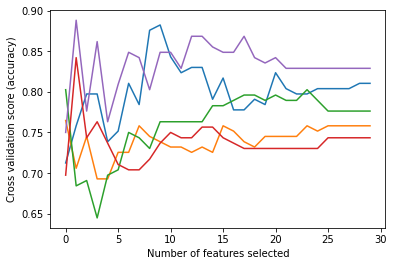

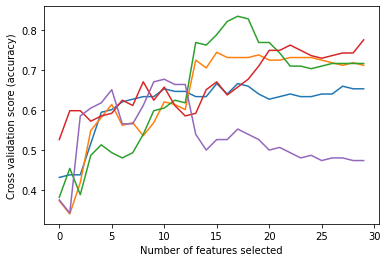

In [162]:
# The best models as seen from grid search
en_estimator1 = LogisticRegression(C=1.0, penalty = 'elasticnet', solver = 'saga', l1_ratio = 1.0)
en_estimator2 = LogisticRegression(C=1.0, penalty = 'elasticnet', solver = 'saga', l1_ratio = 1.0)


rfecv_en1 = RFECV(estimator=en_estimator1, step=1,cv=5, verbose=0)
rfecv_en2 = RFECV(estimator=en_estimator2, step=1,cv=5, verbose=0)

rfecv_en1.fit(X_r,y_r1)
rfecv_en2.fit(X_r,y_r2)

rfecv_en1.transform(X_r)
rfecv_en2.transform(X_r)

clear_output()


print ("Binary Model")
print (rfecv_en1)
print ('Optimal number of features for Binary: ' + str(rfecv_en1.n_features_))
print ('The ranking of the features: ')
print (rfecv_en1.ranking_)
print ("Important Proteins : ") 
print (feature_arr[rfecv_en1.support_])


print ()

print ("Multi Class Model")
print (rfecv_en2)
print ('Optimal number of features Multi-class: '+ str(rfecv_en2.n_features_))
print ('The ranking of the features: ')
print (rfecv_en2.ranking_)
print ("Important Proteins : ") 
print (feature_arr[rfecv_en2.support_])


print ()


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot( range(0, len(rfecv_en1.grid_scores_)), rfecv_en1.grid_scores_, )


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot( range(0, len(rfecv_en2.grid_scores_)), rfecv_en2.grid_scores_, )
plt.show()

##Neural Network

Since REFCV sould not work with I came across this article and chose permutation importance function for feature importance evaluation. 
https://datascience.stackexchange.com/questions/44700/how-do-i-get-the-feature-importace-for-a-mlpclassifier

In [163]:
# The best models as seen from grid search
# the printing format is from the sklearn webpage on of permutation_importance since it was proper and better than what I was coming up with 
nn_model1 = MLPClassifier(activation = 'relu', alpha=0.1, hidden_layer_sizes=(100,), random_state=1, solver='lbfgs').fit(X_r, y_r1)
nn_model2 = MLPClassifier(activation = 'relu', alpha=0.1, hidden_layer_sizes=(100,), random_state=1, solver='lbfgs').fit(X_r, y_r2)



print ("Binary Classification")
r1 = permutation_importance(nn_model1, X, y_val_nn1, n_repeats=30, random_state=0)
features_names = reduced_dataset_df.columns.values.tolist()

for i in r1.importances_mean.argsort()[::-1]:
    if r1.importances_mean[i] - 2 * r1.importances_std[i] > 0:
        print(f"{features_names[i]:<8}"
              f"{r1.importances_mean[i]:.3f}"
              f" +/- {r1.importances_std[i]:.3f}")


print ()
print ("Multi class Classification")
r2 = permutation_importance(nn_model2, X, y_val_nn2, n_repeats=30, random_state=0)
features_names2 = reduced_dataset_df.columns.values.tolist()

for i in r2.importances_mean.argsort()[::-1]:
    if r2.importances_mean[i] - 2 * r2.importances_std[i] > 0:
        print(f"{features_names2[i]:<8}"
              f"{r2.importances_mean[i]:.3f}"
              f" +/- {r2.importances_std[i]:.3f}")

Binary Classification
APP_N   0.224 +/- 0.025
MTOR_N  0.118 +/- 0.012
SYP_N   0.110 +/- 0.016
ITSN1_N 0.099 +/- 0.011
pNR1_N  0.084 +/- 0.013
pPKCG_N 0.075 +/- 0.012
AMPKA_N 0.073 +/- 0.012
TRKA_N  0.065 +/- 0.019
NUMB_N  0.052 +/- 0.009
GluR3_N 0.039 +/- 0.013
pAKT_N  0.038 +/- 0.012
Tau_N   0.034 +/- 0.010
Ubiquitin_N0.031 +/- 0.011
S6_N    0.031 +/- 0.011
pRSK_N  0.017 +/- 0.008
NR2A_N  0.014 +/- 0.006
pMEK_N  0.014 +/- 0.007
GluR4_N 0.008 +/- 0.004

Multi class Classification
APP_N   0.137 +/- 0.017
AMPKA_N 0.134 +/- 0.014
pP70S6_N0.132 +/- 0.019
S6_N    0.119 +/- 0.021
pNR2A_N 0.117 +/- 0.016
NUMB_N  0.116 +/- 0.019
TRKA_N  0.114 +/- 0.023
Tau_N   0.111 +/- 0.021
Ubiquitin_N0.111 +/- 0.018
GluR3_N 0.105 +/- 0.020
pCREB_N 0.100 +/- 0.014
ITSN1_N 0.099 +/- 0.019
MTOR_N  0.097 +/- 0.016
SYP_N   0.084 +/- 0.021
pPKCG_N 0.084 +/- 0.018
pMTOR_N 0.076 +/- 0.017
NR2B_N  0.064 +/- 0.016
pNR1_N  0.059 +/- 0.009
pAKT_N  0.051 +/- 0.011
pCFOS_N 0.047 +/- 0.009
P38_N   0.044 +/- 0.013
NR2A_N  

## SVM

Binary Model
RFECV(cv=5, estimator=SVC(kernel='linear'))
Optimal number of features for Binary: 7
The ranking of the features: 
[20 16  2 17  3  1 23 14 21  4  1  1  1  5  1 11 22  1 10  7 15 13  1 24
 12 18 19  8  6  9]
Important Proteins : 
['pNR1_N' 'APP_N' 'MTOR_N' 'P38_N' 'AMPKA_N' 'NUMB_N' 'GluR3_N']

Multi Class Model
RFECV(cv=5, estimator=SVC(kernel='linear'))
Optimal number of features Multi-class: 22
The ranking of the features: 
[1 1 3 1 5 1 1 1 7 1 1 1 1 1 1 9 2 1 1 1 1 1 1 8 1 6 1 1 1 4]
Important Proteins : 
['ITSN1_N' 'NR2A_N' 'pCREB_N' 'pNR1_N' 'pNR2A_N' 'pRSK_N' 'TRKA_N' 'APP_N'
 'MTOR_N' 'P38_N' 'pMTOR_N' 'AMPKA_N' 'NUMB_N' 'pPKCG_N' 'S6_N'
 'AcetylH3K9_N' 'Tau_N' 'GluR3_N' 'Ubiquitin_N' 'pCFOS_N' 'SYP_N'
 'H3AcK18_N']



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


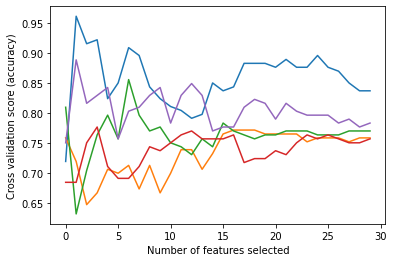

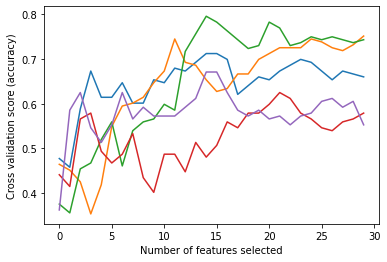

In [164]:
# RFECV had a dilema that it had problems for SVC classfier and could only compute for 'linear' kernel and not 'poly' or 'rbf'
# So I computed for the linear kernel itself.
 # The best models as seen from grid search
svm_estimator1 = SVC(kernel= 'linear')
svm_estimator2 = SVC(kernel= 'linear')


svm_estimator1.fit(X_r,y_r1)
svm_estimator2.fit(X_r,y_r1)

rfecv_svm1 = RFECV(estimator=svm_estimator1, step=1,cv=5, verbose=0)
rfecv_svm2 = RFECV(estimator=svm_estimator2, step=1,cv=5, verbose=0)

rfecv_svm1.fit(X_r,y_r1)
rfecv_svm2.fit(X_r,y_r2)

rfecv_svm1.transform(X_r)
rfecv_svm2.transform(X_r)

clear_output()
print ("Binary Model")
print (rfecv_svm1)
print ('Optimal number of features for Binary: ' + str(rfecv_svm1.n_features_))
print ('The ranking of the features: ')
print (rfecv_svm1.ranking_)
print ("Important Proteins : ") 
print (feature_arr[rfecv_svm1.support_])

print ()


print ("Multi Class Model")
print (rfecv_svm2)
print ('Optimal number of features Multi-class: '+ str(rfecv_svm2.n_features_))
print ('The ranking of the features: ')
print (rfecv_svm2.ranking_)
print ("Important Proteins : ") 
print (feature_arr[rfecv_svm2.support_])

print ()

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot( range(0, len(rfecv_svm1.grid_scores_)), rfecv_svm1.grid_scores_, )


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot( range(0, len(rfecv_svm2.grid_scores_)), rfecv_svm2.grid_scores_, )
plt.show()

## Random Forest

Binary Model
RFECV(cv=5, estimator=RandomForestClassifier(max_depth=50, n_estimators=128))
Optimal number of features for Binary: 28
The ranking of the features: 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2]
Important Proteins : 
['ITSN1_N' 'NR2A_N' 'pAKT_N' 'pCREB_N' 'pMEK_N' 'pNR1_N' 'pNR2A_N'
 'pRSK_N' 'CREB_N' 'TRKA_N' 'APP_N' 'MTOR_N' 'P38_N' 'pMTOR_N' 'AMPKA_N'
 'NR2B_N' 'pP70S6_N' 'pPKCG_N' 'S6_N' 'AcetylH3K9_N' 'Tau_N' 'GluR3_N'
 'GluR4_N' 'Ubiquitin_N' 'BCL2_N' 'pCFOS_N' 'SYP_N' 'H3AcK18_N']

Multi Class Model
RFECV(cv=5, estimator=RandomForestClassifier(max_depth=50, n_estimators=128))
Optimal number of features Multi-class: 4
The ranking of the features: 
[ 5 27  9 22 20 23 10 14 25 18 13 15  1  4 19 16  1  6  1  3  8  2  7 21
  1 17 26 11 12 24]
Important Proteins : 
['P38_N' 'pP70S6_N' 'pPKCG_N' 'Ubiquitin_N']



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


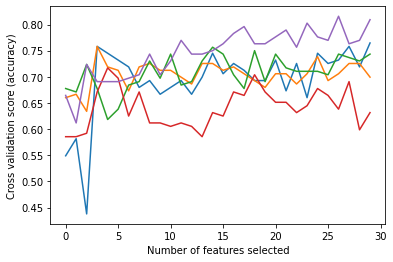

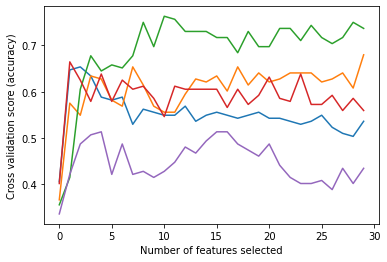

In [165]:
#The best model as found by the grid search 
rf_classifier1 = RandomForestClassifier(max_depth=50, n_estimators=128)
rf_classifier2 = RandomForestClassifier(max_depth=50, n_estimators=128)


rfecv_rf1 = RFECV(estimator=rf_classifier1, step=1,cv=5, verbose=0)
rfecv_rf2 = RFECV(estimator=rf_classifier2, step=1,cv=5, verbose=0)

rfecv_rf1.fit(X_r,y_r1)
rfecv_rf2.fit(X_r,y_r2)

rfecv_rf1.transform(X_r)
rfecv_rf2.transform(X_r)

clear_output()

print ("Binary Model")
print (rfecv_rf1)
print ('Optimal number of features for Binary: ' + str(rfecv_rf1.n_features_))
print ('The ranking of the features: ')
print (rfecv_rf1.ranking_)
print ("Important Proteins : ") 
print (feature_arr[rfecv_rf1.support_])

print ()

print ("Multi Class Model")
print (rfecv_rf2)
print ('Optimal number of features Multi-class: '+ str(rfecv_rf2.n_features_))
print ('The ranking of the features: ')
print (rfecv_rf2.ranking_)
print ("Important Proteins : ") 
print (feature_arr[rfecv_rf2.support_])

print ()


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot( range(0, len(rfecv_rf1.grid_scores_)), rfecv_rf1.grid_scores_, )


# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot( range(0, len(rfecv_rf2.grid_scores_)), rfecv_rf2.grid_scores_, )
plt.show()

# Thus it seems reducing the features would indeed improve the models accuracy.

#REFERENCES:
1. https://scikit-learn.org/stable/index.html
2. https://stackabuse.com/overview-of-classification-methods-in-python-with-scikit-learn/
3. https://towardsdatascience.com/how-to-tackle-any-classification-problem-end-to-end-choose-the-right-classification-ml-algorithm-4d0becc6a295